# Inchworm-like source evolution through a geometrically complex fault fueled persistent supershear rupture during the 2018 Palu Indonesia earthquake
This notebook demonstrates how to reproduce [figures](https://github.com/rokuwaki/2018PaluIndonesia/tree/master/pubFigure) presented in the [manuscript](https://doi.org/10.31223/osf.io/j4cas) and [supplemenary material](https://osf.io/v35uj/).   
[Figure 1](#Figure-1)  
[Figure 2](#Figure-2)  
[Figure 3](#Figure-3)  
[Figure 4](#Figure-4)  
[Figure 5](#Figure-5)  
[Figure 6](#Figure-6)  
[Figure S1](#Figure-S1)  
[Figure S2](#Figure-S2)  
[Figure S3](#Figure-S3)  
[Figure S4](#Figure-S4)  
[Figure S5](#Figure-S5)  
[Figure S6](#Figure-S6)  
[Figure S7](#Figure-S7)  
[Figure S8](#Figure-S8)  
[Figure S9](#Figure-S9)  
[Figure S10](#Figure-S10)  
[Figure S11](#Figure-S11)  
[Movie S1](#Movie-S1)    
[Graphical abstract (von Mises)](#Graphical-abstract-(von-Mises))  
[Graphical abstract (rose diagram)](#Graphical-abstract-(rose-diagram))  

*Following data are not archived here, but available publicly or upon request to the authors.  
- `Bao+2019NatGeosci` https://doi.org/10.1038/s41561-018-0297-z
- `GEBCO_2019_21_Jan_2020_8fb22d7a46d8` https://download.gebco.net/

## Load libraries and parameters

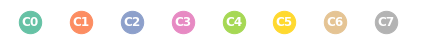

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
figsize = (5.6, 5.6)
import numpy as np
initfontsize=8
import matplotlib as mpl
mpl.rc('axes', labelsize=initfontsize, titlesize=initfontsize)
mpl.rc('xtick', labelsize=initfontsize)
mpl.rc('ytick', labelsize=initfontsize)
mpl.rc('legend', fontsize=initfontsize)
mpl.rc('savefig', dpi=450, transparent=False)
mpl.rc('font', size=initfontsize)
import matplotlib.patheffects as path_effects
from obspy.imaging.beachball import beach
from netCDF4 import Dataset
from matplotlib.colors import LightSource
from matplotlib.colors import LinearSegmentedColormap
def generate_cmap(colors):
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)
bathytopo = generate_cmap(['#0093cf', 'w', '#000000'])
import linecache
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
cmap = plt.get_cmap('Set2', 8)
from cycler import cycler
custom_color_cycle=[]
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    custom_color_cycle.append(str(mpl.colors.rgb2hex(rgb)))
plt.rc('axes', prop_cycle=(cycler(color=custom_color_cycle)))
fig=plt.figure(figsize = figsize); ax=fig.add_axes([0.1, 0.1, 1, 0.06])
for i in range(8):
    ax.scatter(i, 0, s=500)
    ax.text(i, 0, 'C'+str(i), ha='center', va='center', color='white', weight='bold', size=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False); ax.get_xaxis().set_ticks([]); ax.get_yaxis().set_ticks([])
plt.show()
from matplotlib.mlab import griddata
from matplotlib.patches import ArrowStyle
import matplotlib.animation as animation
import os
import subprocess, shlex
#from scipy.stats import binned_statistic
from scipy.stats import vonmises
from scipy.special import iv
from scipy.optimize import minimize
import shapefile
import warnings
warnings.filterwarnings("ignore")
import urllib.request
from bs4 import BeautifulSoup
import requests
import git
import pandas as pd

# locations of bends and Palu bay along strike (358 deg) from the epicenter
bx = [-8, -17, -45, -71, -101, -110] 

def drawinfo(ax, m):
    from matplotlib.markers import MarkerStyle
    
    data=np.loadtxt('NST.txt', delimiter=',', comments='#')
    x, y=m(data[:,0], data[:,1])
    ax.plot(x, y, zorder=2, lw=1, color='C7', alpha=0.85, linestyle='--')

    data=np.loadtxt('PKF.txt', delimiter=',', comments='#')
    x, y=m(data[:,0], data[:,1])
    ax.plot(x, y, zorder=20, lw=1, color='k', alpha=0.85)

    data=np.loadtxt('MF.txt', delimiter=',', comments='#')
    x, y=m(data[:,0], data[:,1])
    ax.plot(x, y, zorder=2, lw=1, color='C7', alpha=0.85)

    data=np.loadtxt('EST.txt', delimiter=',', comments='#')
    x, y=m(data[:,0], data[:,1])
    ax.plot(x, y, zorder=2, lw=1, color='C7', alpha=0.85, linestyle='--')

    data=np.loadtxt('PB2002_BS.txt', delimiter=',', comments='#')
    x, y=m(data[:,0], data[:,1])
    ax.plot(x, y, zorder=2, lw=1, color='C7', alpha=0.85, linestyle='--')

    x, y=m(123, -0.3)
    text=ax.text(x, y, 'Molucca Sea', size=6, color='#003f59')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    x, y=m(124, -5.5)
    text=ax.text(x, y, 'Banda Sea', size=6, color='#003f59')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    x, y=m(120, 2.5)
    text=ax.text(x, y, 'N. Sulawesi trench', size=6, color='C7')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    x, y=m(119.6, 0.55)
    text=ax.text(x, y, 'Palu-Koro fault', size=6, color='k')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])
    
    x, y=m(120.4, -1)
    text=ax.text(x, y, r'$M_{\mathrm{W}}$ 7.6 2018 Palu earthquake', size=6, color='k', bbox=dict(boxstyle="round",
                   ec='C7',fc='w',alpha=0.5))
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])
    
    x, y=m(118.2, -0.8)
    text=ax.text(x, y, 'Makassar trench', size=6, color='C7', rotation=72)
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    x, y=m(120.6, -2.1)
    text=ax.text(x, y, 'Matano fault', size=6, color='C7', rotation=-20)
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    x, y=m(123, -2.5)
    text=ax.text(x, y, 'E. Sulawesi trench', size=6, color='C7')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w', alpha=0.85), path_effects.Normal()])

    lon1=+1.19249E+02
    lon2=+1.19475E+02
    lat1=+7.13724E-01
    lat2=-8.10301E-02
    x1, y1=m(lon1-0.1, lat1-0.1)
    x2, y2=m(lon2-0.1, lat2-0.1)
    arrow_params = {'shape': 'left', 'overhang':1, 'head_width':30000, 'head_length':20000}
    a=286
    dx=np.cos(a*np.pi/180.0)*40000
    dy=np.sin(a*np.pi/180.0)*40000
    ax.arrow(x1, y1, dx, dy, **arrow_params)

    x1, y1=m(lon1+0.1, lat1)
    x2, y2=m(lon2+0.1, lat2)
    a=106
    dx=np.cos(a*np.pi/180.0)*40000
    dy=np.sin(a*np.pi/180.0)*40000
    ax.arrow(x2, y2, dx, dy, **arrow_params)
    
def drawtopo(m, my_example_nc_file, flag, alpha, zorder):
    fh = Dataset(my_example_nc_file, mode='r')
    lons = fh.variables['lon'][:]; lats = fh.variables['lat'][:]; tmax = fh.variables['elevation'][:]
    fh.close()
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    ls = LightSource(azdeg=315, altdeg=45)
    cmap=bathytopo
    tmaxmin=-4000; tmaxmax= 4000#abs(tmaxmin)
    extent = ([xi.min(), xi.max(), yi.min(), yi.max()])
    rgb = ls.shade(tmax, cmap=cmap, blend_mode='overlay', vmin=tmaxmin, vmax=tmaxmax)
    cs = ax.imshow(rgb, interpolation='none', alpha=alpha, cmap=cmap, vmin=tmaxmin, vmax=tmaxmax, \
                 zorder=zorder, origin='lower')
    cs.set_extent(extent)
    return cs

def calc_theta_ml(theta):
    return np.arctan(np.sum(np.sin(theta)) / np.sum(np.cos(theta)))
def calc_A_m_ml(theta, theta_ml):
    return (1.0/len(theta)) * np.sum(np.cos(theta - theta_ml))
def search_m_ml(A_m_ml):
    dx = 1e-4
    kappa_test = np.arange(0, 100+dx, dx)
    for kappa_test in zip(kappa_test):
        diff = np.abs(A_m_ml - iv(1, kappa_test)/iv(0, kappa_test))
        if diff < dx:
            return kappa_test
def search_m_ml_scipy(A, xinit):
    func = (lambda x: np.abs(A - iv(1, x)/iv(0, x)))
    cons = ( {'type': 'ineq', 'fun': lambda x: x} )
    result = minimize(func, x0=xinit, constraints=cons, method="SLSQP")
    return result.x[0]
def von_mises(theta, theta_mu, m):
    return (1.0 / (2.0*np.pi * iv(0, m))) * np.exp(m * np.cos(theta - theta_mu))
def mean_median_std(values):
    x=np.arange(0, len(values), 1)
    nbins=1
    bin_mean, bin_edges, binnumber = binned_statistic(x, values, statistic='mean', bins=nbins)
    bin_median, bin_edges, binnumber = binned_statistic(x, values, statistic='median', bins=nbins)
    bin_sum, bin_edges, binnumber = binned_statistic(x, values**2.0, statistic='sum', bins=nbins)
    bin_count, bin_edges, binnumber = binned_statistic(x, values, statistic='count', bins=nbins)
    std=np.sqrt(bin_sum / bin_count - bin_mean**2.0)
    return bin_mean, bin_median, std
def calc_theta_ml_numpyHist(x, w_hist):
    tmp1 = 0
    tmp2 = 0
    for i in range(len(x)):
        tmp1 = tmp1 + np.sin(x[i]) * w_hist[i]
        tmp2 = tmp2 + np.cos(x[i]) * w_hist[i]
    theta_ml = np.arctan(tmp1 / tmp2)
    return theta_ml
def calc_A_m_ml_numpyHist(x, w_hist, theta_ml):
    tmp = 0
    for i in range(len(x)):
        tmp = tmp + np.cos(x[i] - theta_ml) * w_hist[i]
    A_m_ml = tmp / sum(w_hist)
    return A_m_ml

## Move to data directory

In [3]:
nbpath = '/Users/ryo/GoogleDrive/Work/2018Indonesia/'
os.chdir(nbpath)

datapath = '/Users/ryo/GoogleDrive/Work/2018Indonesia/data/'
os.chdir(datapath)
print('Now at data dir: '+os.getcwd())

Now at data dir: /Users/Ryo/GoogleDrive/Work/2018Indonesia/data


## Figure 1

Loading USGS catalog...
Loading GCMT solution...
Loading plate boundary...
`tectonicplates.git` is already cloned.


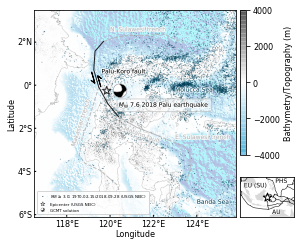

In [113]:
lonmin=116.5; lonmax=125.8; latmin=-6.1; latmax=3.5
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.5; mapheight=mapwidth/aspect
fig=plt.figure(figsize=figsize)
ax=fig.add_axes([0.1, 0.1, mapwidth, mapheight])
axp=ax.get_position()

m.drawparallels(np.arange(-80.,81.,2),labels=[1,0,0,0], fontsize=initfontsize, \
            dashes=(2,10000), color='k')        
m.drawmeridians(np.arange(-180.,181.,2),labels=[0,0,0,1], fontsize=initfontsize, \
            dashes=(2,10000), color='k')
m.drawcoastlines(color='C7', linewidth=0.5, zorder=0)
ax.set_xlabel('Longitude', labelpad=12)
ax.set_ylabel('Latitude', labelpad=18)

drawinfo(ax, m)

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?\
format=csv&starttime=1970-02-15&endtime=2018-09-28&\
minmagnitude=3&minlatitude=-7&minlongitude=116&maxlatitude=4&maxlongitude=126'
filename = './backgroundseism_USGS.txt'
print('Loading USGS catalog...')
urllib.request.urlretrieve(url, filename)
data=np.loadtxt(filename, delimiter=',', skiprows=1, usecols=(1,2,3,4))
lon, lat, mag=data[:,1], data[:,0], data[:,3]
x, y=m(lon, lat)
ax.scatter(x, y, s=1, facecolor='#003f59', alpha=0.5, edgecolor='none')

#data=np.loadtxt('gcmt_psmeca_main.txt', usecols=(0,1,2,3,4,5,6,7,8,9))
#lon, lat, mrr, mtt, mpp, mrt, mrp, mtp = data[0],data[1],data[3],data[4],data[5],data[6],data[7],data[8]
# GCMT solution for the 2018 Palu earthquake (201809281002A)
url = 'http://globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2018&mo=9&\
day=28&oyr=1976&omo=1&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=1&lmw=7&um\
w=10&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9\
999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=6'
print('Loading GCMT solution...')
response = requests.get(url)
response.encoding = response.apparent_encoding 
soup = BeautifulSoup(response.text, 'html.parser') 
psmeca = soup.find_all('pre')[1].get_text(strip=True).split()
#print(psmeca)
lon, lat = float(psmeca[0]), float(psmeca[1])
mrr, mtt, mpp = float(psmeca[3]), float(psmeca[4]), float(psmeca[5])
mrt, mrp, mtp = float(psmeca[6]), float(psmeca[7]), float(psmeca[8])
x, y = m(lon, lat)
x0, y0=x, y
x1, y1=m(lon+0.6, elat)
ax.plot([x0, x1], [y0, y1], lw=0.5, color='C7')
ax = plt.gca()
focmecs=[mrr, mtt, mpp, mrt, mrp, mtp]
b = beach(focmecs, xy=(x1, y1), width=70000, linewidth=0.5, facecolor='k', edgecolor='C7')
b.set_zorder(100); b.set_alpha(1); b.set_clip_on(True)
ax.add_collection(b)

#dummy beachball for legend
x1, y1=m(116.9, -5.78)
b = beach(focmecs, xy=(x1, y1), width=20000, linewidth=0.3, facecolor='k', edgecolor='C7')
b.set_zorder(100); b.set_alpha(1); b.set_clip_on(True)
ax.add_collection(b)

topodata = 'GEBCO_2019_21_Jan_2020_8fb22d7a46d8/gebco_2019_n4.0_s-6.5_w116.0_e126.0.nc'
cstopo=drawtopo(m, topodata, 1, 0.3, 0)

x, y=m(elon, elat)
ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101)
ax.scatter([], [], s=1, facecolor='#003f59', alpha=1, edgecolor='none', 
           label=r'$M_{\mathrm{W}}$ ≥ 3.0; 1970-02-15/2018-09-28 (USGS NEIC)')
ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='k', linewidth=0.5, alpha=0.8, zorder=101, 
           label='Epicenter (USGS NEIC)')
ax.scatter([], [], s=1, facecolor='none', edgecolor='none', label='GCMT solution')
plt.legend(loc=[0.015, 0.015], fontsize=4)
####################
cax=fig.add_axes([axp.x1+0.01, axp.y1-(axp.y1-axp.y0)*0.7, 0.015, (axp.y1-axp.y0)*0.7])
cbar=plt.colorbar(cstopo, cax=cax, ticks=np.linspace(-4000, 4000, 5), label='Bathymetry/Topography (m)')
####################
lonmin=elon-25; lonmax=elon+25; latmin=elat-18; latmax=elat+18
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.135; mapheight=mapwidth/aspect
ax=fig.add_axes([axp.x1+0.01, axp.y0, mapwidth, mapheight])
axp=ax.get_position()
m.fillcontinents(color='C7', alpha=0.5)

print('Loading plate boundary...')
try:
    git.Git('./').clone('https://github.com/fraxen/tectonicplates.git')
except git.GitCommandError as e: 
    print('`tectonicplates.git` is already cloned.')
src = shapefile.Reader('tectonicplates/PB2002_boundaries.shp')
for tmp in src.shapeRecords():
    x = [i[0] for i in tmp.shape.points[:]]
    y = [i[1] for i in tmp.shape.points[:]]
    x, y = m(x, y)
    ax.plot(x, y, color='k', lw=0.5)

axp = ax.get_position()
platename = ['AU', 'EU (SU)', 'PHS']
locx = [axp.x0+0.08, axp.x0+0.01, axp.x0+0.088]
locy = [axp.y0+0.017, axp.y0+0.083, axp.y0+0.094]
for i in range(len(locx)):
    text=fig.text(locx[i], locy[i], platename[i], size=6, color='k', va='top', ha='left')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])

x, y=m(elon, elat)
ax.scatter(x, y, s=80, marker='*', facecolor='w', edgecolor='k', alpha=1, zorder=101)

plt.savefig('../pubFigure/figure1.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figure1.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure 2

190830175253


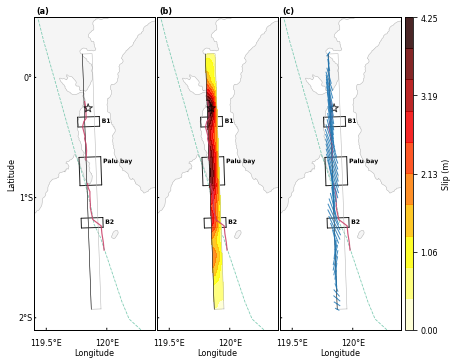

In [5]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
strike_flag=0; slip_flag=0; beach_flag=0
fignums = ['(a)', '(b)', '(c)']
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.4; lonmax=120.4; latmin=-2.1; latmax=0.5
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='h',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.3; mapheight=mapwidth/aspect
fig=plt.figure(figsize=figsize)
j = 4 # main model
print(str(model[j]))
data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
xloc, yloc = data[:,10], data[:,11]
data=np.loadtxt('model_'+str(model[j])+'/knot_value_'+str(model[j])+'.dat_rim', usecols=(2, 3))
limlon, limlat, limlontop, limlattop=data[:,1], data[:,0], data[2:4,1], data[2:4,0]

lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
model_str, model_dip=fort40[0], fort40[1]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
model_t_int, model_jtn=fort40[6], fort40[7]
lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
variance=fort40[0]    
note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+\
str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)
#fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)
cmap=plt.get_cmap('hot_r')
dataInSARnorth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_north.gmt', comments='#')
dataInSARsouth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_south.gmt', comments='#')

for panel in [0, 1, 2]:
    ax=fig.add_axes([0.1+(mapwidth + 0.005)*panel, 0.1, mapwidth, mapheight])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.005, fignums[panel], ha='left', va='bottom', weight='bold')
    m.drawmapboundary(fill_color='#f5f5f5')
    m.fillcontinents(color='w')
    if panel == 0:
        m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
    else:
        m.drawparallels(np.arange(-80.,81.,1),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
    m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,1], fontsize=initfontsize, \
                dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5, zorder=2)
    ax.set_xlabel('Longitude', labelpad=18)
    if panel == 0:
        ax.set_ylabel('Latitude', labelpad=18)

    x, y=m(limlon, limlat)
    ax.plot(x, y, color='C7', zorder=50, lw=0.5, solid_joinstyle='miter', label='Model boundary')
    x, y=m(limlontop, limlattop)
    ax.plot(x, y, color='k', zorder=50, lw=0.5)

    ax = plt.gca()

    if panel == 2:
        for i in np.arange(0, len(strike), 1):
            for k in [0, 180]:
                if yloc[i] == 10.00:
                    g=geod.Direct(lat[i], lon[i], strike[i]+k, slip[i]/max(slip)*2.0*1e4)
                    glon = g['lon1'], g['lon2']
                    glat = g['lat1'], g['lat2']
                    gx, gy = m(glon, glat)
                    ax.plot(gx, gy, color='#1f77b4', linewidth=1, alpha=0.85, zorder=1020)

    if panel == 1:
        xi=np.linspace(lon.min(), lon.max(), 1000)
        yi=np.linspace(lat.min(), lat.max(), 1000)
        X,Y= np.meshgrid(xi,yi)
        X, Y=m(X, Y)
        resampled = griddata(lon, lat, slip, xi, yi,'linear')
        interval = np.linspace(0, max(slip), 11)
        sc=ax.contourf(X, Y, resampled, interval, cmap=cmap, vmin=0, vmax=max(slip), zorder=10, alpha=0.85)

    x, y=m(elon, elat)
    ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=1)
    ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=0.5, 
               label='Epicenter (USGS NEIC)')

    x, y =m(dataInSARnorth[:,0], dataInSARnorth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.2, alpha=0.85, zorder=100, label='Surface-rupture trace (Bao et al. 2019)')
    x, y =m(dataInSARsouth[:,0], dataInSARsouth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.2, alpha=0.85, zorder=100)

    data=np.loadtxt('Belleir2006Tectono_PKF_MF_traced.txt', comments='#')
    sx, sy = 49.35, 49.277
    tmplon, tmplat = data[:,0] / sx + 119.0, - data[:,1] / sy
    tmplon = np.insert(tmplon, 0, 119.346)
    tmplat = np.insert(tmplat, 0, 0.834)
    x, y=m(tmplon, tmplat)
    ax.plot(x, y, zorder=2, lw=0.8, color='C0', alpha=0.85, linestyle='--', 
            label='Palu-Koro fault (Bellier et al. 2006)')

    bend_index = 0
    for k, distance in enumerate(bx):
        g=geod.Direct(elat, elon, 358.0, distance*1e3)
        gx, gy = m(g['lon2'], g['lat2'])
        g_p=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, 10.0*1e3)
        g_m=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, -10.0*1e3)
        glon = g_p['lon2'], g_m['lon2']
        glat = g_p['lat2'], g_m['lat2']
        gx, gy = m(glon, glat)
        ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
        if k%2 == 0:
            g=geod.Direct(g_m['lat2'], g_m['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
            x, y = m(g['lon1']+0.02, g['lat1']-0.02)
            if distance >= -69 and distance <= -45:
                text=ax.text(x, y, 'Palu bay', size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            else:
                bend_index += 1
                text=ax.text(x, y, 'B'+str(bend_index), size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            g=geod.Direct(g_p['lat2'], g_p['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')

    if panel == 2:
        cax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, max(slip), 5), format='%.2f', label='Slip (m)')
plt.savefig('../pubFigure/figure2.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figure2.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure 3

190830175253


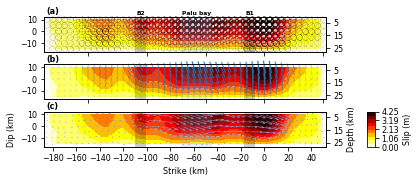

In [6]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]        
    return h0, model_dip, model_icmn, model_str

model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a)', '(b)', '(c)']
cmap=plt.get_cmap('hot_r')
j = 4
data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
print(str(model[j]))
x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
X, Y=np.meshgrid(xi, yi)
zi=griddata(x, y, slip, xi, yi,'linear')
#zi=griddata((x, y), slip, (xi, yi),'linear')
maxslip = max(slip)
interval=np.linspace(0, maxslip, 11)

fig=plt.figure(figsize=figsize)
axw=0.7
axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw

for panel in [0, 1, 2]:

    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')
    interval_50=np.linspace(0, maxslip, 3)
    ax.contour(X, Y, zi, interval_50, colors='C7', linewidths=1, linestyles='--')

    if model_icmn == 5:
        ax = plt.gca()
        if panel == 0:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                          bgcolor='w')
                b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                ax.add_collection(b)
        elif panel == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) 
        elif panel == 2:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)

    ax.axvspan(bx[0], bx[1], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    ax.axvspan(bx[2], bx[3], edgecolor='none', facecolor='C2', zorder=10, alpha=0.2)
    ax.axvspan(bx[4], bx[5], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    if panel == 0:
        ax.text(bx[1] - (bx[1]-bx[0])/2, 13, 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
        ax.text(bx[3] - (bx[3]-bx[2])/2, 13, 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
        ax.text(bx[5] - (bx[5]-bx[4])/2, 13, 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')

    if panel == 2:
        ax.set_xticks(np.arange(-180, 180, 20))
        ax.set_xlabel('Strike (km)')

        #for dis in np.arange(-180, 40, 5):
        #    ax.axvline(dis, lw=0.5)

    if panel == 0 or panel == 1:
        ax.set_xticklabels('')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    #for hline in np.arange(5, 30, 5):
    #    ax2.axhline(hline, lw=0.5)
    ax2.set_ylim(depmin, depmax)

    if panel == 2:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

        cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')    

plt.savefig('../pubFigure/figure3.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figure3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure 4

190830175253


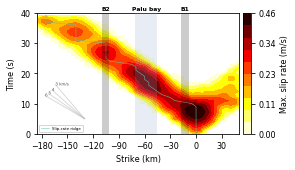

In [7]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for i in [4]:
    print(str(model[i]))
    data=np.loadtxt('model_'+str(model[i])+'/slip-rate-time_along_strike.txt', skiprows=1)
    t, x, amp = data[:,0], data[:,1], data[:,3]
    xs=np.linspace(min(x), max(x), 1000)
    ys=np.linspace(min(t), max(t), 1000)
    X, Y = np.meshgrid(xs, ys)
    Z = griddata(x, t, amp, X, Y,'linear')
    levels = np.linspace(0, max(amp), 11)

    fig=plt.figure(figsize=figsize)
    ax=fig.add_axes([0.1, 0.1, 0.5, 0.3])
    axp=ax.get_position()

    lines=linecache.getlines('model_'+str(model[i])+'/fort.40')
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn=fort40[6], fort40[7]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '\
    +str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)+' (= '+str((model_jtn+1)*0.5)+' s)'
    #fig.text(axp.x0, axp.y1+0.004, '← South', va='bottom', ha='left', size=6)
    #fig.text(axp.x1, axp.y1+0.004, 'North →', va='bottom', ha='right', size=6)

    sc = ax.contourf(X, Y, Z, levels=levels, cmap='hot_r', vmin=0, vmax=max(amp))

    ax.axvspan(bx[0], bx[1], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    ax.text(bx[1] - (bx[1]-bx[0])/2, 40.5, 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axvspan(bx[2], bx[3], edgecolor='none', facecolor='C2', zorder=10, alpha=0.2)
    ax.text(bx[3] - (bx[3]-bx[2])/2, 40.5, 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axvspan(bx[4], bx[5], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    ax.text(bx[5] - (bx[5]-bx[4])/2, 40.5, 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')

    for j in np.arange(3, 7, 1):
        x0, x1 = -130, -180 + (7-j) * 4
        y0, y1 = 5, abs((x1-x0)/j) + 5
        ax.plot([x0, x1], [y0, y1], color='C7', lw=1, alpha=0.5)
        if j == 3:
            text=ax.text(x1, y1, str(j)+' km/s', alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)     
        else:
            text=ax.text(x1, y1, str(j), alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])
        
    pick_t = []
    pick_x = []
    for j in np.arange(0, 40, 1):
        tmpamp = [amp[i] for i in range(len(amp)) if t[i] == j]
        tmpx = [x[i] for i in range(len(amp)) if t[i] == j]
        tmpt = [t[i] for i in range(len(amp)) if t[i] == j]
        pick_t.append(tmpt[0])
        pick_x.append(tmpx[np.argmax(tmpamp)])
    ax.plot(pick_x, pick_t, color='C0', label='Slip-rate ridge', lw=0.5)

    plt.legend(loc='lower left', fontsize=4)

    
    #for dis in np.arange(-180, 40, 5):
    #    ax.axvline(dis, lw=0.5)
    #for hline in np.arange(0, 40, 1):
    #    ax.axhline(hline, lw=0.5)
    ax.set_xlabel('Strike (km)')
    ax.set_ylabel('Time (s)')
    ax.set_xticks(np.arange(-180, 120, 30))
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(0, max(t)+1)
    axp=ax.get_position()
    cbar_ax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
    cbar=plt.colorbar(sc, cax=cbar_ax, label='Max. slip rate (m/s)', ticks=np.linspace(0, max(amp), 5), format='%.2f')
    plt.savefig('../pubFigure/figure4.png', bbox_inches="tight", pad_inches=0.1)
    plt.savefig('../pubFigure/figure4.pdf', bbox_inches="tight", pad_inches=0.1)
    plt.show()

## Figure 5

190830175253
t = 1
t = 8
t = 11
t = 14
t = 17
t = 18
t = 21
t = 24
t = 27
t = 28
t = 31
t = 34
t = 37


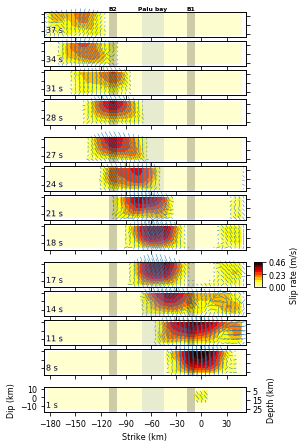

In [9]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for j in np.arange(4, 5, 1):
    print(str(model[j]))
    maxsliprateall = np.loadtxt('model_'+str(model[j])+'/snap_1s_201.txt', usecols=8, skiprows=1)[0]
    lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
    fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]

    fig=plt.figure(figsize=(5.6, 5.6))
    for snap in [1, 8, 11, 14, 17, 18, 21, 24, 27, 28, 31, 34, 37]:  #this is for TR = 0.5
        print('t =', snap)
        data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+snap)+'.txt', skiprows=1)
        x, y, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
        strike, dip, rake=data[:,9], data[:,10], data[:,11]

        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
        X, Y=np.meshgrid(xi, yi)
        zi=griddata(x, y, avesliprate, xi, yi,'linear')
        interval=np.linspace(0, maxsliprateall, 11)
        
        axw=0.5
        axh=(max(yi)-min(yi)) / (max(xi)-min(xi)) * axw
        xloc=0.1
        if snap == 1:
            yloc = 0.1
        elif snap == 8:
            yloc=axp.y1 + 0.03
        elif snap == 18:
            yloc=axp.y1 + 0.03
        elif snap == 28:
            yloc=axp.y1 + 0.03
        else:
            yloc=axp.y1 + 0.01

        ax=fig.add_axes([xloc,yloc,axw,axh])
        axp=ax.get_position()
        note=str(int(data[0:1,7][0])) + ' s'
        text=fig.text(axp.x0+0.005, axp.y0+0.005, note, va='bottom', ha='left', size=8)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxsliprateall, cmap='hot_r')

        if j < 6:
            for k in np.arange(0, len(strike), 1):
                a=0.5*np.pi - strike[k]*np.pi/180.0
                length=avesliprate[k]/2.0*60
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                if avesliprate[k] > 0:
                    ax.plot([x1, x2], [y1, y2], alpha=1, lw=0.5, clip_on=False, color='#1f77b4')        
        axp0=ax.get_position()
        ax2 = ax.twinx()
        depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
        depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
        ax2.set_yticks(np.arange(-5, 40, 10))
        ax2.set_ylim(depmin, depmax)

        if snap == 1:
            ax.set_xlabel('Strike (km)')
            ax.set_ylabel('Dip (km)')
            ax2.set_ylabel('Depth (km)')

        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])

        ax.set_xticks(np.arange(-180, 180, 30))
        ax.set_xlim(min(xi), max(xi))
        ax.set_ylim(min(yi), max(yi))
        
        ax.axvspan(bx[0], bx[1], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
        ax.axvspan(bx[2], bx[3], edgecolor='none', facecolor='C2', zorder=10, alpha=0.2)
        ax.axvspan(bx[4], bx[5], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
        if snap == 37:
            ax.text(bx[1] - (bx[1]-bx[0])/2, 13, 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
            ax.text(bx[3] - (bx[3]-bx[2])/2, 13, 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
            ax.text(bx[5] - (bx[5]-bx[4])/2, 13, 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')

        if snap == 17:
            axp0=ax.get_position()
            cax=fig.add_axes([axp0.x1+0.02, axp0.y0, 0.02, axp0.y1-axp0.y0])
            cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxsliprateall, 3), \
                              format='%.2f', label='Slip rate (m/s)')
    
    plt.savefig('../pubFigure/figure5.png', bbox_inches='tight', pad_inches=0.1)
    plt.savefig('../pubFigure/figure5.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

## Figure 6

190830175253


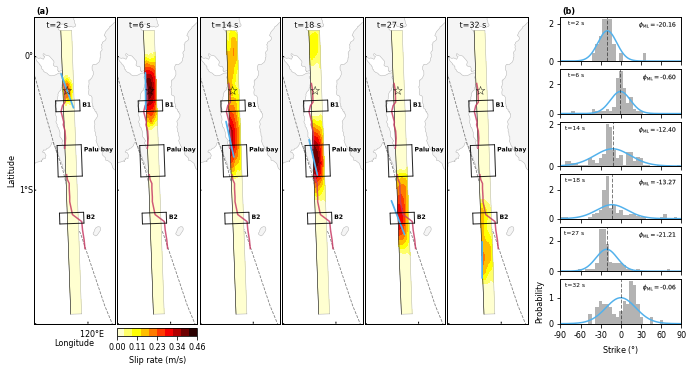

In [5]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
j = 4 # main model
print(str(model[j]))
snapind = [207, 214, 218, 228]
m_mllist = []; m_mllist_weight = []
latlist = []
figlocind = 0
figlochori = 0

fig=plt.figure(figsize=figsize)
#for panel in np.arange(1, 41, 1):
for panel in [2, 6, 14, 18, 27, 32]:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+panel)+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]; maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    latlist.append(lat[argmaxslip])
    tmp = []; slipHist = []
    for i in range(len(strike)):
        tmp0 = strike[i]
        if tmp0 > 88 and tmp0 < 268:
            tmp0 = tmp0 + 180
        if slip[i] > 0:
            tmp.append(tmp0)
            slipHist.append(slip[i])
    for i in range(len(tmp)):
        if tmp[i] > 180:
            tmp[i] = tmp[i] - 360
        
    tmp = np.array(tmp)
    theta = tmp * np.pi/180.0
    theta_ml = calc_theta_ml(theta)
    A_m_ml = calc_A_m_ml(theta, theta_ml)
    #m_ml = search_m_ml(A_m_ml)
    m_ml_scipy = search_m_ml_scipy(A_m_ml, 1.0)

    #print(panel, m_ml[0] - m_ml_scipy, '(Diff: m_ml homemade - m_ml scipy)')
    
    
    if panel == 1 or panel == 11 or panel == 21 or panel == 31:
        figlocind = 1
        figlochori += 1
        
    #x0=1.1250000000000002, y0=0.1, x1=1.3250000000000002, y1=0.8616710895255245)
    initialyloc = 0.8616710895255245 - 0.1102785149
    ax=fig.add_axes([1.3250000000000002 + 0.08, initialyloc - 0.1302785149 * (figlocind), 0.3, 0.1102785149])
    figlocind += 1
    axp=ax.get_position()
    ax2 = ax.twiny()

    bins=np.linspace(-np.pi, np.pi, 72)
    ax2.hist(theta, density=True, bins=bins, color='C7')
    x = np.linspace(-np.pi, np.pi, 1000)
    ax2.plot(x, vonmises.pdf(x, m_ml_scipy, loc=theta_ml), color='#52b1ec', lw=1.5)
    ax2.axvline(theta_ml, color='k', linestyle='--', lw=1, zorder=10, alpha=0.5)
    
    ## Numpy style
    #w_hist, bin_edges = np.histogram(theta, bins=bins, density=True, weights=slipHist)
    #x = [ (bin_edges[i-1]+bin_edges[i])/2 for i in range(1, len(bin_edges)) ]
    #ax2.bar(x, w_hist, color='C7', width=0.085)

    #tmp_ml = calc_theta_ml_numpyHist(x, w_hist)
    #tmp_A_m_ml = calc_A_m_ml_numpyHist(x, w_hist, tmp_ml)
    #tmp_m_ml_scipy = search_m_ml_scipy(tmp_A_m_ml, 1.0)
    #x = np.linspace(-np.pi, np.pi, 1000)
    #ax2.plot(x, vonmises.pdf(x, tmp_m_ml_scipy, loc=tmp_ml), color='#52b1ec', lw=1)
    #ax2.axvline(tmp_ml, color='k', linestyle='--', lw=1, zorder=100, alpha=0.5)
    ##

    
    ax2.set_xlim(-np.pi / 2, np.pi / 2)
    ax2.set_xticklabels([])
    ax2.set_xticks([])

    #xdeg=np.arange(-180, 180+45, 45)
    xdeg=np.arange(-90, 90+30, 30)
    ax.set_xticks(xdeg)
    ax.set_xticklabels([])
    if panel == 32:
        ax.set_xlabel('Strike ($\degree$)')
        ax.set_ylabel('Probability')
        ax.set_xticklabels(xdeg)
    tmp1 = theta_ml*180/np.pi
    m_mllist.append(tmp1)
    #tmp2 = tmp_ml*180/np.pi
    #m_mllist_weight.append(tmp2)
    textbody = r'$\phi_{\rm{ML}}=$'+'{:1.2f}'.format(tmp1)
    #textbody2 = r'$\phi_{\rm{ML}}=$'+'{:1.2f}'.format(tmp2)
    fig.text(axp.x0+0.06, axp.y1-0.01, 't='+str(panel)+' s', va='top', ha='right', size=6)
    text = fig.text(axp.x1-0.01, axp.y1-0.01, textbody, va='top', ha='right', size=6)
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    #text = fig.text(axp.x1-0.01, axp.y1-0.01, textbody2, va='top', ha='right', size=6)
    #text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    if panel == 2:
        axp = ax.get_position()
        fig.text(axp.x0+0.005, axp.y1+0.001, '(b)', ha='left', va='bottom', weight='bold')
#print(len(m_mllist), len(m_mllist_weight))  
############################################################################
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
strike_flag=0; slip_flag=0; beach_flag=0
fignums = ['(a)', '(b)', '(c)']
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.6; lonmax=120.2; latmin=-2; latmax=0.3
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='h',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.2; mapheight=mapwidth/aspect
j = 4 # main model
data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
xloc, yloc = data[:,10], data[:,11]
data=np.loadtxt('model_'+str(model[j])+'/knot_value_'+str(model[j])+'.dat_rim', usecols=(2, 3))
limlon, limlat, limlontop, limlattop=data[:,1], data[:,0], data[2:4,1], data[2:4,0]

lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
model_str, model_dip=fort40[0], fort40[1]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
model_t_int, model_jtn=fort40[6], fort40[7]
lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
variance=fort40[0]    
note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+\
str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)
#fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)
cmap=plt.get_cmap('hot_r')
#cmap=plt.get_cmap('cividis')

dataInSARnorth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_north.gmt', comments='#')
dataInSARsouth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_south.gmt', comments='#')
snapind = [202, 206, 214, 218, 227, 232]
timeind = [2, 6, 14, 18, 27, 32]
for panel in [0, 1, 2, 3, 4, 5]:
    ax=fig.add_axes([0.1+(mapwidth + 0.005)*panel, 0.1, mapwidth, mapheight])
    axp=ax.get_position()
    text = fig.text(axp.x0+0.03, axp.y1-0.01, 't='+str(timeind[panel])+' s', ha='left', va='top')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=1), path_effects.Normal()])
    m.drawmapboundary(fill_color='#f5f5f5')
    m.fillcontinents(color='w')
    if panel == 0:
        m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
        ax.set_xlabel('Longitude', labelpad=18)
        fig.text(axp.x0+0.11, axp.y0-0.01, '120$\degree$E', va='top')        
        axp = ax.get_position()
        fig.text(axp.x0+0.005, axp.y1+0.001, '(a)', ha='left', va='bottom', weight='bold')

        ax.set_ylabel('Latitude', labelpad=18)
        ax.set_xlabel('Longitude', labelpad=15)
    else:
        m.drawparallels(np.arange(-80.,81.,1),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5, zorder=2)

    x, y=m(limlon, limlat)
    ax.plot(x, y, color='C7', zorder=50, lw=0.5, solid_joinstyle='miter')
    x, y=m(limlontop, limlattop)
    ax.plot(x, y, color='k', zorder=50, lw=0.5)

    ax = plt.gca()

    #if panel == 1:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(snapind[panel])+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]
    maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    #lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
    #xloc, yloc = data[:,10], data[:,11]
    xi=np.linspace(lon.min(), lon.max(), 1000)
    yi=np.linspace(lat.min(), lat.max(), 1000)
    X,Y= np.meshgrid(xi,yi)
    X, Y=m(X, Y)
    resampled = griddata(lon, lat, slip, xi, yi,'linear')
    interval = np.linspace(0, maxslip, 11)
    sc=ax.contourf(X, Y, resampled, interval, cmap=cmap, vmin=0, vmax=maxslip, zorder=10, alpha=1)

    x, y=m(elon, elat)
    ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=0.5)
    #ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='C7', alpha=0.8, zorder=101, lw=0.5, 
    #           label='Epicenter (USGS NEIC)')
    
    x, y =m(dataInSARnorth[:,0], dataInSARnorth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100, label='Surface-rupture trace (Bao et al. 2019)')
    x, y =m(dataInSARsouth[:,0], dataInSARsouth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100)

    data=np.loadtxt('Belleir2006Tectono_PKF_MF_traced.txt', comments='#')
    sx, sy = 49.35, 49.277
    tmplon, tmplat = data[:,0] / sx + 119.0, - data[:,1] / sy
    tmplon = np.insert(tmplon, 0, 119.346)
    tmplat = np.insert(tmplat, 0, 0.834)
    x, y=m(tmplon, tmplat)
    ax.plot(x, y, zorder=2, lw=0.8, color='k', alpha=0.5, linestyle='--', 
            label='Palu-Koro fault (Bellier et al. 2006)')
    #if panel == 3:
    #    plt.legend(loc='upper right', fontsize=5)

    arrow_params = {'shape': 'full', 'overhang':0.5, 'head_width':0, 'head_length':0}
    '''
    for pm in [0, 180]:
        a = strike[argmaxslip] + pm
        g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 20*1e3)
        x, y = m(lon[argmaxslip], lat[argmaxslip])
        ax.scatter(x, y, s=2, color='C0', zorder=100)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                 **arrow_params, color='C0', lw=1.5, zorder=100, alpha=0.85)
    '''
    for pm in [0, 180]:
        a = m_mllist[panel] + pm
        g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 15*1e3)
        x, y = m(lon[argmaxslip], lat[argmaxslip])
        #ax.scatter(x, y, s=2, color='#52b1ec', zorder=10000)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.plot([spoint[0], epoint[0]], [spoint[1], epoint[1]], color='#52b1ec', lw=1.75, zorder=100, alpha=1, solid_capstyle='round')
        #ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
        #         **arrow_params, color='#52b1ec', lw=1.75, zorder=100, alpha=1)

    ## Numpy style wight
    #for pm in [0, 180]:
    #    a = m_mllist_weight[panel] + pm
    #    g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 15*1e3)
    #    x, y = m(lon[argmaxslip], lat[argmaxslip])
    #    #ax.scatter(x, y, s=2, color='#52b1ec', zorder=10000)
    #    spoint = [x, y]
    #    x, y = m(g['lon2'], g['lat2'])
    #    epoint = [x, y]
    #    #ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
    #    #         **arrow_params, color='#52b1ec', lw=1.75, zorder=100, alpha=1)
    ##
        
    bend_index = 0
    for k, distance in enumerate(bx):
        g=geod.Direct(elat, elon, 358.0, distance*1e3)
        gx, gy = m(g['lon2'], g['lat2'])
        g_p=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, 10.0*1e3)
        g_m=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, -10.0*1e3)
        glon = g_p['lon2'], g_m['lon2']
        glat = g_p['lat2'], g_m['lat2']
        gx, gy = m(glon, glat)
        ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
        if k%2 == 0:
            g=geod.Direct(g_m['lat2'], g_m['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
            x, y = m(g['lon1']+0.02, g['lat1']-0.02)
            if distance >= -69 and distance <= -45:
                text=ax.text(x, y, 'Palu bay', size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            else:
                bend_index += 1
                text=ax.text(x, y, 'B'+str(bend_index), size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            g=geod.Direct(g_p['lat2'], g_p['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')

    if panel == 1:
        cax=fig.add_axes([axp.x0, axp.y0-0.03, axp.x1-axp.x0, 0.02])
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip rate (m/s)', orientation='horizontal')
plt.savefig('../pubFigure/figure6.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figure6.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S1

190830175253


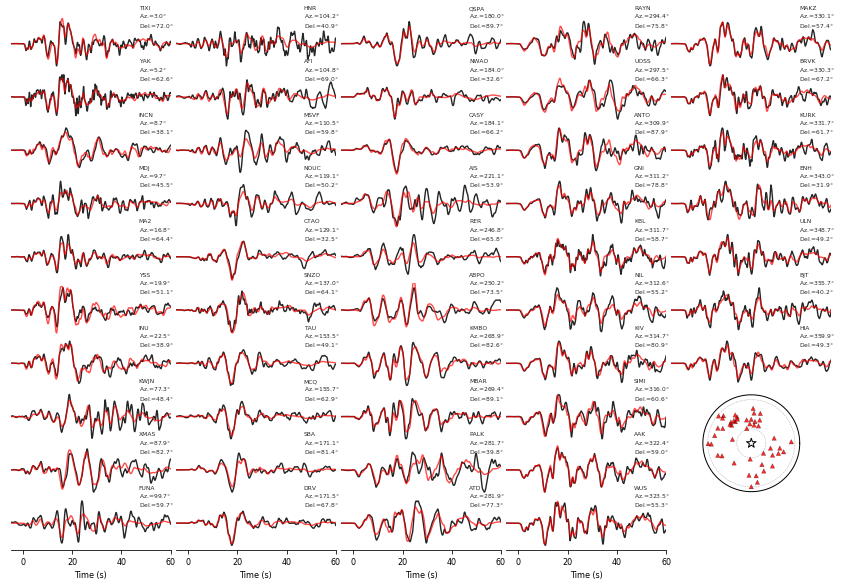

In [14]:
def aziequi(ax, stalist):
    data = np.loadtxt(stalist, usecols=(5, 4))
    d, a = (data[:, 0], 90-data[:,1])
    x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
    sc=ax.scatter(x, y, s=20, marker='^', edgecolor='none', facecolor='r', alpha=0.85)
    sc=ax.scatter(x, y, s=20, marker='^', edgecolor='k', facecolor='none', alpha=1, lw=0.2)
    stalist=np.loadtxt(stalist, usecols=(0), dtype=str)
    #for (i, staname) in enumerate(stalist):
        #text = ax.text(x[i], y[i], staname, size=2, va='center')
        #text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    ax.scatter(0, 0, s=100, marker='*', edgecolor='k', facecolor='none')
    theta=np.linspace(0, 360, 360)
    for i in [30, 90]:
        x, y=(i*np.cos(theta*np.pi/180.0), i*np.sin(theta*np.pi/180.0))
        ax.plot(x, y, color='C7', zorder=0, solid_capstyle='round', lw=0.5, linestyle='--')
    x, y=(100*np.cos(theta*np.pi/180.0), 100*np.sin(theta*np.pi/180.0))
    ax.plot(x, y, color='k', solid_capstyle='round', lw=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([]) 
    return sc

def drawobssyn(ax, obsdata, syndata, alpha):
    data=np.loadtxt(obsdata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C7', lw=0.2, alpha=alpha)
    data=np.loadtxt(syndata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C3', lw=0.2, alpha=alpha)
def fittings(sta, x0, y1, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, flag, azi, dis):
    j=0
    for i in np.arange(0, len(modelid), 1):
        ax=fig.add_axes([x0,y1-height*j,width,height])
        drawobssyn(ax, 'model_'+modelid+'/obssyn/obs_'+sta+'.txt', \
                   'model_'+modelid+'/obssyn/syn_'+sta+'.txt', 0.85)
        cmap=plt.get_cmap('RdYlBu')
        color = cmap(dep[i]/maxdepofcolor)
        if flag == 1:
            ax.scatter(mint, 0, s=20, marker='*', edgecolor='C7', lw=0.3, zorder=20, color=color, clip_on=False)
            #ax.text(-5, -0.3, r'$h_{0}$='+str('%.1f' % dep[i]), ha='left', va='top', size=6, color='C7')
        ax.set_xlim([mint, maxt])
        ax.set_ylim([-1, 1])
#        ax.plot([0, 0],[-1, 1], lw=0.1)
        if i==0:
            ax.text(mint, 1, sta+'\nAz.='+str(azi)+'$\degree$\nDel.='+str(dis)+'$\degree$', \
                    va='bottom', ha='left', size=6, color='C7', clip_on=False)
        #if i==numwave-1:
        if i==12:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([0, 30, 60])
            ax.set_xticklabels([0, 30, 60], size=6)
            ax.set_xlabel('Time (s)', size=6)
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([])
        j+=1
    return ax, cmap

model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for k in np.arange(4, 5, 1):
    w = 7.4; h = 7.4; wh=w/h
    fig=plt.figure(figsize=(w, h))
    modelid=str(model[k])
    print(modelid)
    alpha=0.85
    axw=0.3
    axh=0.1
    stalist=np.loadtxt('model_'+str(model[k])+'/station_'+str(model[k])+'.list', usecols=(0), dtype=str)
    stadata=np.loadtxt('model_'+str(model[k])+'/station_'+str(model[k])+'.list', usecols=(4, 5))
    azi, dis=(stadata[:,0], stadata[:,1])
    for i in np.arange(0, len(stalist), 1):
        num = 10
        mod = i // num
        if i == 0:
            ax=fig.add_axes([0.1, 0.1, axw, axh])
            axp=ax.get_position()
            axp0=ax.get_position()
            #fig.text(axp.x0, axp.y1+0.03, str(pwd)+', '+modelid, va='bottom', ha='left')
        elif i == num*(mod):
            ax=fig.add_axes([axp0.x1+axw*(mod-1)+0.01*(mod), axp0.y0, axw, axh])
            axp=ax.get_position()
        elif i > num*(mod) and i < num*(mod+1):
            ax=fig.add_axes([axp.x0, axp.y0-axh, axw, axh])
            axp=ax.get_position()

        if i == num*(mod+1)-1:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks(np.arange(0, 80, 20))
            ax.set_xticklabels(np.arange(0, 80, 20), size=8)
            ax.set_xlabel('Time (s)', size=8)
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([]) 

        sta=stalist[i]
        obsdata='model_'+modelid+'/obssyn/obs_'+sta+'.txt'
        syndata='model_'+modelid+'/obssyn/syn_'+sta+'.txt'

        data=np.loadtxt(obsdata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='k', lw=1.4, alpha=alpha)
        data=np.loadtxt(syndata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='r', lw=1.4, alpha=0.7)
        fig.text(axp.x1-0.06, axp.y1+0.02, sta+'\nAz.='+str(azi[i])+'$\degree$\nDel.='+str(dis[i])+'$\degree$', \
                            va='top', ha='left', size=6, color='k', clip_on=False, alpha=alpha)
        ax.set_ylim([-1.2, 1.2])
        ax.set_xlim([-5, 60])
        
    ax=fig.add_axes([axp.x0+0.05, axp.y0-0.2, 0.2, 0.2])
    axp=ax.get_position()
    sc = aziequi(ax, 'model_'+modelid+'/station_'+modelid+'.list')

    plt.savefig('../pubFigure/figureS1.png', bbox_inches="tight", pad_inches=0.1)
    plt.savefig('../pubFigure/figureS1.pdf', bbox_inches="tight", pad_inches=0.1)
    plt.show()

## Figure S2

190904092511
190904092534


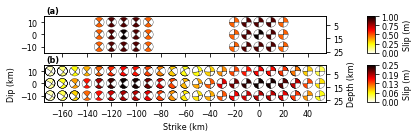

In [15]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a)', '(b)', '(c)']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [11, 12]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0:
        ax.set_xticklabels([])
    if panel == 1:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 1:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1

plt.savefig('../pubFigure/figureS2.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS2.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S3

190827153432
190903103328


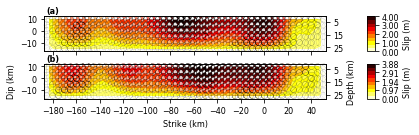

In [16]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a)', '(b)', '(c)']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [5, 13]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0:
        ax.set_xticklabels([])
    if panel == 1:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 1:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1

plt.savefig('../pubFigure/figureS3.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S4

200108095516
190830175253


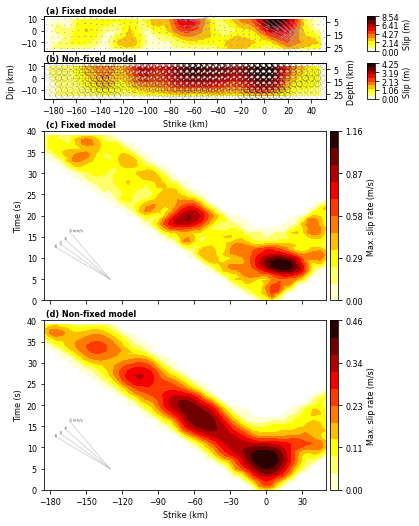

In [17]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a) Fixed model', '(b) Non-fixed model', '(c) Fixed model', '(d) Non-fixed model']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [10, 4]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0:
        ax.set_xticklabels([])
    if panel == 1:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 1:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1

model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for i in [10, 4]:
    data=np.loadtxt('model_'+str(model[i])+'/slip-rate-time_along_strike.txt', skiprows=1)
    t, x, amp = data[:,0], data[:,1], data[:,3]
    xs=np.linspace(min(x), max(x), 1000)
    ys=np.linspace(min(t), max(t), 1000)
    X, Y = np.meshgrid(xs, ys)
    Z = griddata(x, t, amp, X, Y,'linear')
    levels = np.linspace(0, max(amp), 11)

    axp = ax.get_position()    
    ax=fig.add_axes([axp.x0, axp.y0 - 0.5 + 0.03*(panel-2), 0.7, 0.42])
    axp = ax.get_position()    
    fig.text(axp.x0+0.005, axp.y1+0.005, fignums[panel], ha='left', va='bottom', weight='bold')

    lines=linecache.getlines('model_'+str(model[i])+'/fort.40')
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn=fort40[6], fort40[7]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)+' (= '+str((model_jtn+1)*0.5)+' s)'
    #fig.text(axp.x0, axp.y1+0.004, '← South', va='bottom', ha='left', size=6)
    #fig.text(axp.x1, axp.y1+0.004, 'North →', va='bottom', ha='right', size=6)

    sc = ax.contourf(X, Y, Z, levels=levels, cmap='hot_r', vmin=0, vmax=max(amp))

    for j in np.arange(3, 7, 1):
        x0, x1 = -130, -180 + (7-j) * 4
        y0, y1 = 5, abs((x1-x0)/j) + 5
        ax.plot([x0, x1], [y0, y1], color='C7', lw=1, alpha=0.5)
        if j == 3:
            text=ax.text(x1, y1, str(j)+' km/s', alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)     
        else:
            text=ax.text(x1, y1, str(j), alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])
        
    if panel == 2:
        ax.set_xticklabels([])
    if panel == 3:
        ax.set_xlabel('Strike (km)')
    ax.set_ylabel('Time (s)')
    ax.set_xticks(np.arange(-180, 120, 30))
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(0, max(t)+1)
    axp=ax.get_position()
    cbar_ax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
    cbar=plt.colorbar(sc, cax=cbar_ax, label='Max. slip rate (m/s)', ticks=np.linspace(0, max(amp), 5), format='%.2f')
    
    panel += 1
    
plt.savefig('../pubFigure/figureS4.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS4.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S5

191112034616
190830175253
191112234311


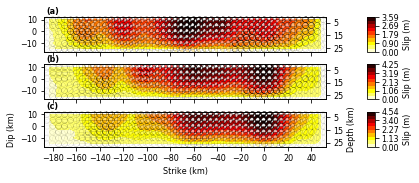

In [18]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a)', '(b)', '(c)']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [1, 4, 7]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0 or panel == 1:
        ax.set_xticklabels([])
    if panel == 2:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 2:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1

plt.savefig('../pubFigure/figureS5.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS5.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S6

191121022524
190830175253
190827153432


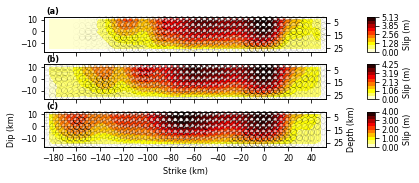

In [19]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a)', '(b)', '(c)']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [3, 4, 5]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.03)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.002, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0 or panel == 1:
        ax.set_xticklabels([])
    if panel == 2:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 2:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1

plt.savefig('../pubFigure/figureS6.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS6.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S7

4.0 0
5.0 1
6.0 2
4.0 3
5.0 4
6.0 5
4.0 6
5.0 7
6.0 8


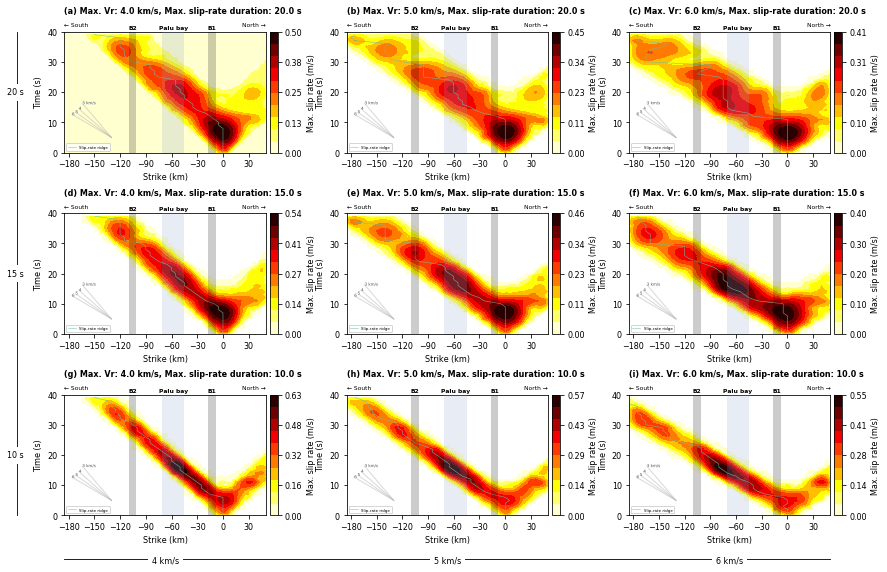

In [20]:
fig=plt.figure(figsize=figsize)
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
panel_num = ['(g)','(h)','(i)','(d)','(e)','(f)','(a)','(b)','(c)']
for i in np.arange(0, 9, 1):
    data=np.loadtxt('model_'+str(model[i])+'/slip-rate-time_along_strike.txt', skiprows=1)
    t, x, amp = data[:,0], data[:,1], data[:,3]
    xs=np.linspace(min(x), max(x), 1000)
    ys=np.linspace(min(t), max(t), 1000)
    X, Y = np.meshgrid(xs, ys)
    Z = griddata(x, t, amp, X, Y,'linear')
    levels = np.linspace(0, max(amp), 11)

    if i == 0:
        ax=fig.add_axes([0.1, 0.1, 0.5, 0.3])
        axp0=ax.get_position()
        text= fig.text(axp0.x0 + (axp0.x1-axp0.x0)/2, axp0.y0-0.1, str(i+4)+' km/s', ha='center', va='top', size=initfontsize, bbox=dict(fc='w', ec='none'))
        text = fig.text(axp0.x0 - 0.1, axp0.y0 + (axp0.y1-axp0.y0)/2.0, '10 s', ha='right', va='center', size=initfontsize, bbox=dict(fc='w', ec='none'))
        
        ax.plot([min(x), 708], [-14.5, -14.5], lw=0.85, color='k', clip_on=False)
        ax.plot([-240, -240], [0, 160], lw=0.85, color='k', clip_on=False)
        
    elif i == 1 or i == 2:
        ax=fig.add_axes([axp0.x1+(axp0.x1-axp0.x0)*(i-1)+0.2*i, axp0.y0, (axp0.x1-axp0.x0), (axp0.y1-axp0.y0)])    
        text = fig.text(axp.x1 + (axp.x1-axp.x0)/2 + 0.2, axp0.y0-0.1, str(i+4)+' km/s', ha='center', va='top', size=initfontsize, bbox=dict(fc='w', ec='none'))
    elif i == 3 or i == 4 or i == 5:
        ax=fig.add_axes([axp0.x0+(axp0.x1-axp0.x0)*(i-3)+0.2*(i-3), axp0.y1 + 0.15, (axp0.x1-axp0.x0), (axp0.y1-axp0.y0)])    
    elif i == 6 or i == 7 or i == 8:
        ax=fig.add_axes([axp0.x0+(axp0.x1-axp0.x0)*(i-6)+0.2*(i-6), axp0.y1 + (axp0.y1-axp0.y0) + 0.3, (axp0.x1-axp0.x0), (axp0.y1-axp0.y0)])    
    if i == 4:
        text = fig.text(axp0.x0 - 0.1, axp0.y1 + ((axp0.y1-axp0.y0)/2.0) + 0.15, '15 s', ha='right', va='center', size=initfontsize, bbox=dict(fc='w', ec='none'))
    if i == 7:
        text = fig.text(axp0.x0 - 0.1, axp0.y1 + ((axp0.y1-axp0.y0)/2.0) * 3 + 0.3, '20 s', ha='right', va='center', size=initfontsize, bbox=dict(fc='w', ec='none'))
    axp=ax.get_position()

    lines=linecache.getlines('model_'+str(model[i])+'/fort.40')
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn=fort40[6], fort40[7]
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+\
    str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)+' (= '+str((model_jtn+1)*0.5)+' s)'
    fig.text(axp.x0, axp.y1+0.01, '← South', va='bottom', ha='left', size=6)
    fig.text(axp.x1, axp.y1+0.01, 'North →', va='bottom', ha='right', size=6)
    fig.text(axp.x0, axp.y1+0.04, panel_num[i] + ' Max. Vr: '+str(vr)+' km/s, Max. slip-rate duration: '+str((model_jtn + 1) * model_t_int) + ' s', 
             va='bottom', ha='left', size=initfontsize, weight='bold')

    sc = ax.contourf(X, Y, Z, levels=levels, cmap='hot_r', vmin=0, vmax=max(amp))

    if len(amp) == 1920:
        pick_t = []
        pick_x = []
        for j in np.arange(0, 40, 1):
            tmpamp = [amp[i] for i in range(len(amp)) if t[i] == j]
            tmpx = [x[i] for i in range(len(amp)) if t[i] == j]
            tmpt = [t[i] for i in range(len(amp)) if t[i] == j]
            pick_t.append(tmpt[0])
            pick_x.append(tmpx[np.argmax(tmpamp)])
        ax.plot(pick_x, pick_t, color='C0', label='Slip-rate ridge', lw=0.5)
        pick_t = []
        pick_x = []
        for j in np.arange(0, 48, 1):
            i0 = j * 40
            i1 = (j+1) * 40
            #print(i0, i1)
            pick_t.append(t[np.argmax(amp[i0:i1])])
            pick_x.append(x[i0])
        #ax.plot(pick_x, pick_t, color='C2', linestyle='--', lw=0.75, label='Slip-rate ridge in space')
        plt.legend(loc='lower left', fontsize=4)
    ax.axvspan(bx[0], bx[1], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    ax.text(bx[1] - (bx[1]-bx[0])/2, 40.5, 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axvspan(bx[2], bx[3], edgecolor='none', facecolor='C2', zorder=10, alpha=0.2)
    ax.text(bx[3] - (bx[3]-bx[2])/2, 40.5, 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axvspan(bx[4], bx[5], edgecolor='none', facecolor='k', zorder=10, alpha=0.2)
    ax.text(bx[5] - (bx[5]-bx[4])/2, 40.5, 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')

    for j in np.arange(3, 7, 1):
        x0, x1 = -130, -180 + (7-j) * 4
        y0, y1 = 5, abs((x1-x0)/j) + 5
        ax.plot([x0, x1], [y0, y1], color='C7', lw=1, alpha=0.5)
        if j == 3:
            text=ax.text(x1, y1, str(j)+' km/s', alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)     
        else:
            text=ax.text(x1, y1, str(j), alpha=0.5, size=4, color='k', ha='left', va='center', zorder=10)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.5), path_effects.Normal()])


    ax.set_xlabel('Strike (km)')
    ax.set_ylabel('Time (s)')
    ax.set_xticks(np.arange(-180, 120, 30))
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(0, max(t)+1)
    axp=ax.get_position()
    cbar_ax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
    cbar=plt.colorbar(sc, cax=cbar_ax, label='Max. slip rate (m/s)', ticks=np.linspace(0, max(amp), 5), format='%.2f')
    print(vr, i)
plt.savefig('../pubFigure/figureS7.png', bbox_inches="tight", pad_inches=0.1)
plt.savefig('../pubFigure/figureS7.pdf', bbox_inches="tight", pad_inches=0.1)
plt.show()

## Figure S8

190830175253
200111235628


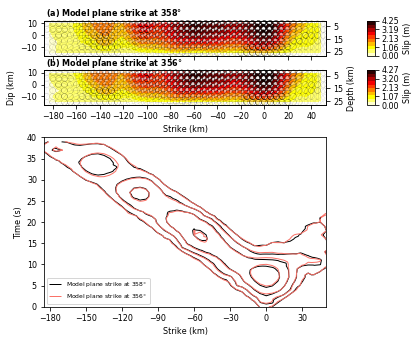

In [21]:
def load_setting_fort40(file):
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=1, skip_footer=len(lines)-2)
    moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
    fort40=np.genfromtxt(file, skip_header=3, skip_footer=len(lines)-4)
    model_str, model_dip=fort40[0], fort40[1]
    fort40=np.genfromtxt(file, skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    lines=linecache.getlines(file)
    fort40=np.genfromtxt(file, skip_header=7, skip_footer=len(lines)-8)
    variance=fort40[0]    
    
    return h0, model_dip, model_icmn, model_str

#static distribution
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)

strike_flag = 0
rake_flag = 0
beach_flag = 1
fignums = ['(a) Model plane strike at 358$\degree$', '(b) Model plane strike at 356$\degree$', '(c)']
fig=plt.figure(figsize=figsize)

#for j in np.arange(0, 5, 1):
panel = 0
for j in [4, 9]:
    data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
    print(str(model[j]))
    x, y, slip, strike, dip, rake=data[:,10], data[:,11],data[:,1], data[:,7], data[:,8],data[:,9]

    if model[j] == 190904092511 or model[j] == 190904092534:
        xi=np.linspace(min(x)-5, max(x)+5, 100)
        yi=np.linspace(min(y)-5, max(y)+5, 100)
    else:
        xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
        yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, slip, xi, yi,'linear')
    maxslip = max(slip)
    interval=np.linspace(0, maxslip, 11)

    axw=0.7
    axh=(abs(max(yi)-min(yi))) / (abs(max(xi)-min(xi))) * axw
    
    ax=fig.add_axes([0.1,0.1 - (axh + 0.035)*panel,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0+0.005, axp.y1+0.001, fignums[panel], ha='left', va='bottom', weight='bold')

    h0, model_dip, model_icmn, model_str=load_setting_fort40('model_'+str(model[j])+'/fort.40')
    if model_icmn == 2.0:
        flag = 'Fixed'
    else:
        flag = 'Non-fixed'
    note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+')'+', '+flag
    #fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)

    if model[j] == 190904092511 or model[j] == 190904092534:
        pass
    else: 
        sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxslip, cmap='hot_r')

    if model_icmn == 5:
        cmap=plt.get_cmap('hot_r')
        ax = plt.gca()
        if beach_flag == 1:
            for i in range(len(strike)):
                focmecs=[strike[i], dip[i], rake[i]]
                color=cmap(slip[i]/max(slip))
                if model[j] == 190904092511 or model[j] == 190904092534:
                    if slip[i] > 0:
                        b = beach(focmecs, xy=(x[i], y[i]), width=8, linewidth=0.3, facecolor=color, edgecolor='k', \
                                  bgcolor='w')
                        b.set_zorder(1); b.set_alpha(1); b.set_clip_on(False)
                        ax.add_collection(b)
                else:
                    b = beach(focmecs, xy=(x[i], y[i]), width=5, linewidth=0.3, facecolor=color, edgecolor='k', \
                              bgcolor='w')
                    b.set_zorder(1); b.set_alpha(slip[i]/max(slip)); b.set_clip_on(False)
                    ax.add_collection(b)
        elif strike_flag == 1:
            for k in np.arange(0, len(strike), 1):
                length=slip[k]/maxslip*5.0
                a=0.5*np.pi - strike[k]*np.pi/180.0
                x1=x[k]+np.cos(a)*length
                y1=y[k]+np.sin(a)*length
                x2=x[k]+np.cos(-(np.pi - a))*length
                y2=y[k]+np.sin(-(np.pi - a))*length
                #ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.5, clip_on=False, color='C4', zorder=1000)  #rake angle
                ax.plot([x1, x2], [y1, y2], alpha=slip[k]/maxslip, lw=1.2, clip_on=False, color='#1f77b4', zorder=1000) #strike orientation
        elif rake_flag == 1:
            for i in np.arange(0, len(strike), 1):
                a=rake[i]*np.pi/180.0
                length=slip[i] / maxslip * 15.0
                x1=np.cos(a)*length
                y1=np.sin(a)*length
                spoint = [x[i], y[i]]
                epoint = [x1+x[i], y1+y[i]]
                arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
                ax.annotate('', xy=epoint, xytext=spoint, 
                            arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    elif model_icmn == 2:
        for i in np.arange(0, len(strike), 1):
            a=rake[i]*np.pi/180.0
            length=slip[i] / maxslip * 20.0
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            spoint = [x[i], y[i]]
            epoint = [x1+x[i], y1+y[i]]
            arrowstyle = ArrowStyle('->', head_length=0.4 * slip[i]/max(slip) * 0.75, head_width=0.2 * slip[i]/max(slip) * 0.5)
            ax.annotate('', xy=epoint, xytext=spoint, 
                        arrowprops=dict(arrowstyle=arrowstyle, color='C2', lw=0.5), annotation_clip=False)


    ax.set_xticks(np.arange(-180, 180, 20))
    if panel == 0:
        ax.set_xticklabels([])
    if panel == 1:
        ax.set_xlabel('Strike (km)')
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))

    ax2 = ax.twinx()
    depmin=h0-np.sin(model_dip*np.pi/180.0)*min(yi)
    depmax=h0-np.sin(model_dip*np.pi/180.0)*max(yi)
    ax2.set_yticks(np.arange(-5, 40, 10))
    ax2.set_ylim(depmin, depmax)

    if panel == 1:
        ax.set_ylabel('Dip (km)')
        ax2.set_ylabel('Depth (km)')

    cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.02, axp.y1-axp.y0])
    if model[j] == 190904092511 or model[j] == 190904092534:
        bounds = interval
        norm = mpl.colors.Normalize(vmin=0, vmax=max(slip))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap='hot_r',norm=norm, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)')
    else:
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip (m)') 
        
    panel += 1
    
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
axp = ax.get_position()    
ax=fig.add_axes([axp.x0, axp.y0 - 0.5 + 0.03*(panel-2), 0.7, 0.42])
axp = ax.get_position()    

i_model = 4 #base model
j_model = 9 #comparison
label_i = 'Model plane strike at 358$\degree$'
label_j = 'Model plane strike at 356$\degree$'

data=np.loadtxt('model_'+str(model[i_model])+'/slip-rate-time_along_strike.txt', skiprows=1)
t, x, amp = data[:,0], data[:,1], data[:,3]
xs=np.linspace(min(x), max(x), 1000)
ys=np.linspace(min(t), max(t), 1000)
X, Y = np.meshgrid(xs, ys)
Z = griddata(x, t, amp, X, Y,'linear')
#levels = np.linspace(0, 0.5, 11)
#levels = np.linspace(0.1, max(amp), 5)
levels = np.arange(0.1, max(amp), 0.1)
cs_i = ax.contour(X, Y, Z, levels=levels, colors='k', alpha=1, linewidths=1, zorders=0)

data=np.loadtxt('model_'+str(model[j_model])+'/slip-rate-time_along_strike.txt', skiprows=1)
t, x, amp = data[:,0], data[:,1], data[:,3]
xs=np.linspace(min(x), max(x), 1000)
ys=np.linspace(min(t), max(t), 1000)
X, Y = np.meshgrid(xs, ys)
Z = griddata(x, t, amp, X, Y,'linear')
#levels = np.linspace(0, 0.5, 11)
levels = np.linspace(0.1, max(amp), 5)
levels = np.arange(0.1, max(amp), 0.1)
cs_j = ax.contour(X, Y, Z, levels=levels, colors='#FA7268', alpha=1, linewidths=1, zorders=10000)

cs_i.collections[0].set_label(label_i)    
cs_j.collections[0].set_label(label_j)    
#cs356.collections[0].set_label('$\phi=356\degree$')    
#cs358.collections[0].set_label('$\phi=358\degree$')    
plt.legend(loc='lower left', fontsize=6)

ax.set_xlabel('Strike (km)')
ax.set_ylabel('Time (s)')
ax.set_xticks(np.arange(-180, 120, 30))
ax.set_xlim(min(x), max(x))
ax.set_ylim(0, max(t)+1)
    
plt.savefig('../pubFigure/figureS8.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS8.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S9

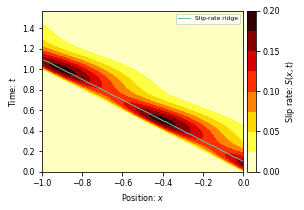

In [22]:
def step_func(x):
    return 1.0 * (x > 0)
def slip_vel_func(t, d):
    f = t * np.exp(-t / d) * step_func(t)
    return f
def amp_func(x):
    a = 4.0 + np.cos(4.0 * np.pi * x)
    return a
def pseudo_slip_Ax(X, T, d):
    p = amp_func(X) * slip_vel_func(T+X, d)
    return p
def pseudo_slip_At(X, T, d):
    p = amp_func(T) * slip_vel_func(T+X, d)
    return p

fig=plt.figure(figsize=figsize)
ax=fig.add_axes([0,0,0.5,0.4])
axp=ax.get_position()

x = np.linspace(-2, 2, 1000)
t = np.linspace(-1, np.pi, 1000)
d = 0.1
X, T = np.meshgrid(x, t)
Z = pseudo_slip_At(X, T, d)
vmin = 0; vmax = 0.2
interval=np.linspace(vmin, vmax, 9)
sc=ax.contourf(X, T, Z, interval, vmin=vmin, vmax=vmax, cmap='hot_r')

xloc = [ X[j][np.argmax(Z[j][:])] for j in range(len(t))]
tloc = [ T[j][np.argmax(Z[j][:])] for j in range(len(t))]

xloc = [ x[np.argmax(Z[j])] for j in range(len(t)) ]
ax.plot(xloc, t, label='Slip-rate ridge', lw=1)

ax.set_xlim(-1, 0)
ax.set_ylim(0, np.pi * 0.5)
ax.set_xlabel('Position: $x$')
ax.set_ylabel('Time: $t$')

plt.legend(loc = 'upper right', fontsize=6)

cax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(vmin, vmax, 5), format='%.2f', label='Slip rate: $S(x, t)$')    

plt.savefig('../pubFigure/figureS9.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS9.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S10

Loading Wolrd Stress Map...


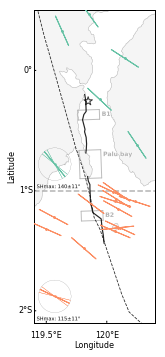

In [114]:
print('Loading Wolrd Stress Map...')
url = 'ftp://datapub.gfz-potsdam.de/download/10.5880.WSM.2016.001/wsm2016.csv'
filename = './wsm2016.csv'
urllib.request.urlretrieve(url, filename)
df = pd.read_csv('wsm2016.csv', usecols=['LAT', 'LON', 'AZI', 'SD'])
wsm2016lon, wsm2016lat, wsm2016azi, wsm2016qua = np.array(df['LON']), np.array(df['LAT']), np.array(df['AZI']), np.array(df['SD'])

data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.4; lonmax=120.4; latmin=-2.1; latmax=0.5

wlonN = [wsm2016lon[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= -1 and wsm2016lat[i] <= latmax]
wlatN = [wsm2016lat[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= -1 and wsm2016lat[i] <= latmax]
waziN = [wsm2016azi[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= -1 and wsm2016lat[i] <= latmax]

wlonS = [wsm2016lon[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= latmin and wsm2016lat[i] < -1]
wlatS = [wsm2016lat[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= latmin and wsm2016lat[i] < -1]
waziS = [wsm2016azi[i] for i in range(len(wsm2016lon)) if wsm2016lon[i] >= lonmin and wsm2016lon[i] <= lonmax and wsm2016lat[i] >= latmin and wsm2016lat[i] < -1]

waziN = np.array(waziN)
waziS = np.array(waziS)

m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='h',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.3; mapheight=mapwidth/aspect
fig=plt.figure(figsize=figsize)
ax=fig.add_axes([0.1, 0.1, mapwidth, mapheight])
axp=ax.get_position()

m.drawmapboundary(fill_color='#f5f5f5')
m.fillcontinents(color='w')
m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
            dashes=(2,10000), color='k')        
m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,1], fontsize=initfontsize, \
            dashes=(2,10000), color='k')
m.drawcoastlines(color='C7', linewidth=0.5, zorder=2)
ax.set_xlabel('Longitude', labelpad=18)
ax.set_ylabel('Latitude', labelpad=18)


x, y=m(elon, elat)
ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=1)
ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=0.5, label='Epicenter (USGS NEIC)')

data=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_north.gmt', comments='#')
x, y =m(data[:,0], data[:,1])
ax.plot(x, y, color='k', lw=1.2, alpha=0.85, zorder=100, label='Surface-rupture trace (Bao et al. 2019)')
data=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_south.gmt', comments='#')
x, y =m(data[:,0], data[:,1])
ax.plot(x, y, color='k', lw=1.2, alpha=0.85, zorder=100)

data=np.loadtxt('Belleir2006Tectono_PKF_MF_traced.txt', comments='#')
sx, sy = 49.35, 49.277
lon, lat = data[:,0] / sx + 119.0, - data[:,1] / sy
lon = np.insert(lon, 0, 119.346)
lat = np.insert(lat, 0, 0.834)
x, y=m(lon, lat)
ax.plot(x, y, zorder=2, lw=0.8, color='k', alpha=0.85, linestyle='--', label='Palu-Koro fault (Bellier et al. 2006)')

for i in np.arange(0, 160, 2):
    g=geod.Direct(elat, elon, 178, i*1e3)
    x, y = m(g['lon2'], g['lat2'])
    #ax.scatter(x, y, s=1, zorder=100)
    
arrow_params = {'shape': 'full', 'overhang':0.5, 'head_width':0, 'head_length':0}
for i in range(len(wlonN)):
    for pm in [0, 180]:
        a = waziN[i] + pm
        g = geod.Direct(wlatN[i], wlonN[i], a, 15*1e3)
        x, y = m(wlonN[i], wlatN[i])
        ax.scatter(x, y, s=2, color='C0', zorder=100)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                 **arrow_params, color='C0', lw=1, zorder=100)        

for i in range(len(wlonS)):
    for pm in [0, 180]:
        a = waziS[i] + pm
        g = geod.Direct(wlatS[i], wlonS[i], a, 15*1e3)
        x, y = m(wlonS[i], wlatS[i])
        ax.scatter(x, y, s=2, color='C1', zorder=100)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                 **arrow_params, color='C1', lw=1, zorder=100)        

lon0list = [119.57, 119.57]
lat0list = [-0.78, -1.88]
wazilist = [waziN, waziS]
colorlist = ['C0', 'C1']

for k in range(2):
    wazi = wazilist[k]
    lon0 = lon0list[k]
    lat0 = lat0list[k]
    x, y = m(lon0, lat0)
    ax.scatter(x, y, s=2, color=colorlist[k], zorder=100)
    spoint = [x, y]
    a = np.linspace(0, 360, 100)
    alon = [ geod.Direct(lat0, lon0, a[i], 15*1e3)['lon2'] for i in range(len(a)) ]
    alat = [ geod.Direct(lat0, lon0, a[i], 15*1e3)['lat2'] for i in range(len(a)) ]
    x, y = m(alon, alat)
    ax.plot(x, y, color='k', lw=0.1)
    alist = [np.mean(wazi), np.mean(wazi)+180, np.mean(wazi) + np.std(wazi), np.mean(wazi) - np.std(wazi), 
             np.mean(wazi) + np.std(wazi) + 180, np.mean(wazi) - np.std(wazi) + 180]
    for aindex, a in  enumerate(alist):
        g = geod.Direct(lat0, lon0, a, 15*1e3)
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        #np.mean(wazi), np.median(wazi), np.std(wazi)
        arrow_params = {'shape': 'full', 'overhang':0.5, 'head_width':0, 'head_length':0}
        if aindex >= 2:
            ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                     **arrow_params, color=colorlist[k], lw=0.3, zorder=100)        
        else:
            ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                     **arrow_params, color=colorlist[k], lw=1, zorder=200)        

    x, y = m(lon0-0.15, lat0-0.15)
    text = ax.text(x, y, 'SHmax: '+str('{:.0f}'.format(np.mean(wazi))) + \
                   '$\pm$'+str('{:.0f}'.format(np.std(wazi)))+'$\degree$', size=5, ha='left', va='top')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=1), path_effects.Normal()])

x0, y0 = m(lonmin, -1)
x1, y1 = m(lonmax, -1)
ax.plot([x0, x1], [y0, y1], color='C7', linestyle='--')


bend_index = 0
for k, distance in enumerate(bx):
    g=geod.Direct(elat, elon, 358.0, distance*1e3)
    gx, gy = m(g['lon2'], g['lat2'])
    g_p=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, 10.0*1e3)
    g_m=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, -10.0*1e3)
    glon = g_p['lon2'], g_m['lon2']
    glat = g_p['lat2'], g_m['lat2']
    gx, gy = m(glon, glat)
    if distance >= -69 and distance <= -45:
        ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
    else:
        ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
    if k%2 == 0:
        g=geod.Direct(g_m['lat2'], g_m['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
        glon = g['lon1'], g['lon2']
        glat = g['lat1'], g['lat2']
        gx, gy = m(glon, glat)
        x, y = m(g['lon1']+0.02, g['lat1']-0.02)
        if distance >= -69 and distance <= -45:
            ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
            text=ax.text(x, y, 'Palu bay', size=6, weight='bold', color='C7', va='top', ha='left')
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
        else:
            ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1, solid_capstyle='round')
            bend_index += 1
            text=ax.text(x, y, 'B'+str(bend_index), size=6, weight='bold', color='C7', va='top', ha='left')
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
        g=geod.Direct(g_p['lat2'], g_p['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
        glon = g['lon1'], g['lon2']
        glat = g['lat1'], g['lat2']
        gx, gy = m(glon, glat)
        x, y = m(g['lon1']+0.02, g['lat1']-0.02)
        if distance >= -69 and distance <= -45:
            ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')
        else:
            ax.plot(gx, gy, color='C7', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')

plt.savefig('../pubFigure/figureS10.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS10.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Figure S11

190830175253


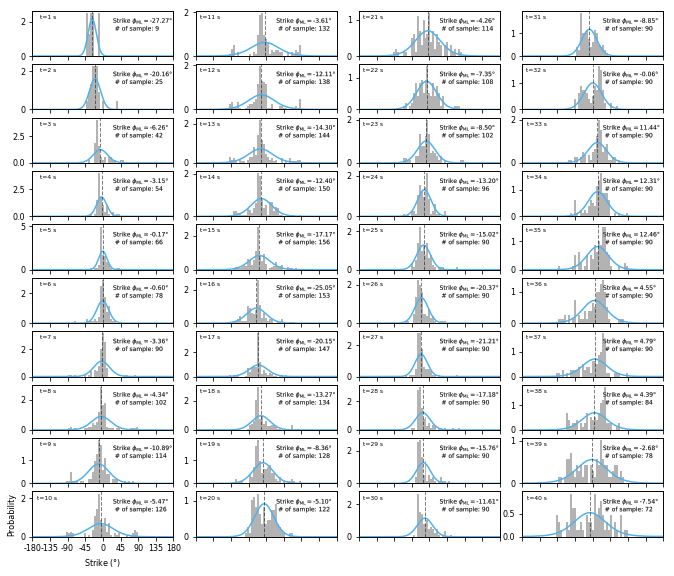

In [25]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
j = 4 # main model
print(str(model[j]))
snapind = [207, 214, 218, 228]
m_mllist = []
latlist = []
figlocind = 0
figlochori = 0

fig=plt.figure(figsize=(5.6, 5.6))
for panel in np.arange(1, 41, 1):
#for panel in [2, 7, 14, 18, 27, 32]:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+panel)+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]; maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    latlist.append(lat[argmaxslip])
    tmp = []; slipHist = []
    for i in range(len(strike)):
        tmp0 = strike[i]
        if tmp0 > 88 and tmp0 < 268:
            tmp0 = tmp0 + 180
        if slip[i] > 0:
            tmp.append(tmp0)
            slipHist.append(slip[i])
    for i in range(len(tmp)):
        if tmp[i] > 180:
            tmp[i] = tmp[i] - 360
        
    tmp = np.array(tmp)
    theta = tmp * np.pi/180.0
    theta_ml = calc_theta_ml(theta)
    A_m_ml = calc_A_m_ml(theta, theta_ml)
    #m_ml = search_m_ml(A_m_ml)
    m_ml_scipy = search_m_ml_scipy(A_m_ml, 1.0)

    #print(panel, m_ml[0] - m_ml_scipy, '(Diff: m_ml homemade - m_ml scipy)')
    
    
    if panel == 1 or panel == 11 or panel == 21 or panel == 31:
        figlocind = 1
        figlochori += 1
        
    ax=fig.add_axes([0.1 + 0.405 * figlochori, 0.1 - 0.1324870553529789 * (figlocind), 0.35, 0.11248705535297888])
    figlocind += 1
    axp=ax.get_position()
    ax2 = ax.twiny()

    bins=np.linspace(-np.pi, np.pi, 72)
    ax2.hist(theta, density=True, bins=bins, color='C7')
    x = np.linspace(-np.pi, np.pi, 1000)
    ax2.plot(x, vonmises.pdf(x, m_ml_scipy, loc=theta_ml), color='#52b1ec', lw=1.5)
    ax2.axvline(theta_ml, color='k', linestyle='--', lw=1, zorder=10, alpha=0.5)
    
    ## Numpy style
    #w_hist, bin_edges = np.histogram(theta, bins=bins, density=True, weights=slipHist)
    #x = [ (bin_edges[i-1]+bin_edges[i])/2 for i in range(1, len(bin_edges)) ]
    #ax2.bar(x, w_hist, color='C7', width=0.085)

    #tmp_ml = calc_theta_ml_numpyHist(x, w_hist)
    #tmp_A_m_ml = calc_A_m_ml_numpyHist(x, w_hist, tmp_ml)
    #tmp_m_ml_scipy = search_m_ml_scipy(tmp_A_m_ml, 1.0)
    #x = np.linspace(-np.pi, np.pi, 1000)
    #ax2.plot(x, vonmises.pdf(x, tmp_m_ml_scipy, loc=tmp_ml), color='#52b1ec', lw=1)
    #ax2.axvline(tmp_ml, color='k', linestyle='--', lw=1, zorder=100, alpha=0.5)
    ##

    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_xticklabels([])
    ax2.set_xticks([])

    xdeg=np.arange(-180, 180+45, 45)
    #xdeg=np.arange(-90, 90+30, 30)
    ax.set_xticks(xdeg)
    ax.set_xticklabels([])
    if panel == 10:
        ax.set_xlabel('Strike ($\degree$)')
        ax.set_ylabel('Probability')
        ax.set_xticklabels(xdeg)
    tmp1 = theta_ml*180/np.pi
    #tmp2 = tmp_ml*180/np.pi
    m_mllist.append(tmp1)
    textbody = 'Strike '+r'$\phi_{\rm{ML}}=$'+'{:1.2f}'.format(tmp1)+\
                 '$\degree$\n # of sample: '+str(len(tmp))
    #textbody2 = 'Strike '+r'$\phi_{\rm{ML}}=$'+'{:1.2f}'.format(tmp2)+\
    #             '$\degree$\n # of sample: '+str(len(tmp))
    fig.text(axp.x0+0.06, axp.y1-0.01, 't='+str(panel)+' s', va='top', ha='right', size=6)
    text = fig.text(axp.x1-0.15, axp.y1-0.01, textbody, va='top', ha='left', size=6)
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    #text = fig.text(axp.x1-0.15, axp.y1-0.01, textbody2, va='top', ha='left', size=6)
    #text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    
plt.savefig('../pubFigure/figureS11.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureS11.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Movie S1

190830175253


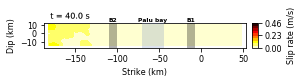

In [26]:
def update(i, ax, cax, fig, axp, j):
    model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
    maxsliprateall = np.loadtxt('model_'+str(model[j])+'/snap_1s_201.txt', usecols=8, skiprows=1)[0]
    if i != 0:
        ax.cla()
        cax.cla()
    
    snap=i + 1
    #print(snap)
    
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+snap)+'.txt', skiprows=1)
    x, y, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
    strike, dip, rake=data[:,9], data[:,10], data[:,11]

    xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
    yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    X, Y=np.meshgrid(xi, yi)
    zi=griddata(x, y, avesliprate, xi, yi,'linear')
    interval=np.linspace(0, maxsliprateall, 11)

    axw=0.5
    axh=(max(yi)-min(yi)) / (max(xi)-min(xi)) * axw
    xloc=0.1
    if snap == 1:
        yloc = 0.1
    elif snap >= 2:
        yloc=axp.y1 + 0.01

    note='t = '+str(data[0:1,7][0]) + ' s'
    text=ax.text(-180, 15, note, va='bottom', ha='left', size=initfontsize)
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
    sc=ax.contourf(X, Y, zi, interval, vmin=0, vmax=maxsliprateall, cmap='hot_r')

    for k in np.arange(0, len(strike), 1):
        a=0.5*np.pi - strike[k]*np.pi/180.0
        length=avesliprate[k]/2.0*120
        x1=x[k]+np.cos(a)*length
        y1=y[k]+np.sin(a)*length
        x2=x[k]+np.cos(-(np.pi - a))*length
        y2=y[k]+np.sin(-(np.pi - a))*length
        #if avesliprate[k] > 0:
        #    ax.plot([x1, x2], [y1, y2], alpha=1, lw=0.5, clip_on=False, color='C0')        

    for vr in np.arange(5, 6, 1):
        az = np.arange(-np.pi, np.pi, 0.01)
        xr = np.cos(az) * data[0:1,7][0] * vr
        yr = np.sin(az) * data[0:1,7][0] * vr
        ax.plot(xr, yr, color='C7', lw=2, alpha=0.85)
    ax.set_xlim(min(xi), max(xi))
    ax.set_ylim(min(yi), max(yi))
    ax.set_xlabel('Strike (km)')
    ax.set_ylabel('Dip (km)')
    
    cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxsliprateall, 3), \
                      format='%.2f', label='Slip rate (m/s)')
    ax.axvspan(bx[0], bx[1], edgecolor='none', facecolor='k', zorder=10, alpha=0.3)
    ax.axvspan(bx[2], bx[3], edgecolor='none', facecolor='C2', zorder=10, alpha=0.3)
    ax.axvspan(bx[4], bx[5], edgecolor='none', facecolor='k', zorder=10, alpha=0.3)
    ax.text(bx[1] - (bx[1]-bx[0])/2, 13, 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.text(bx[3] - (bx[3]-bx[2])/2, 13, 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.text(bx[5] - (bx[5]-bx[4])/2, 13, 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')
    
def draw():
    model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
    snap=4
    j=4
    print(str(model[j]))
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+snap)+'.txt', skiprows=1)
    x, y, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
    xi=np.linspace(min(x)-2.5, max(x)+2.5, 100)
    yi=np.linspace(min(y)-2.5, max(y)+2.5, 100)
    axw=0.5
    axh=(max(yi)-min(yi)) / (max(xi)-min(xi)) * axw
    xloc=0.1
    yloc = 0.1
    fig=plt.figure(figsize=(5.6/1.3, 5.6/5))

    ax=fig.add_axes([0.15,0.45, axw*1.3, axh*5])
    axp=ax.get_position()
    axp0=ax.get_position()
    cax=fig.add_axes([axp0.x1+0.02, axp0.y0, 0.02, axp0.y1-axp0.y0])
    ani = animation.FuncAnimation(fig, update, fargs = (ax, cax, fig, axp, j), interval = 100, frames = 40)
    ani.save('../pubFigure/movieS1.mp4', writer='ffmpeg', fps=8)
    
draw()

## Graphical abstract (von Mises)

190830175253


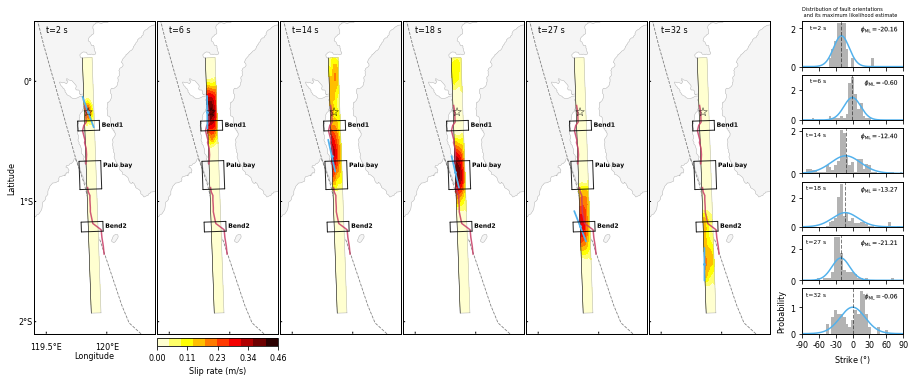

In [27]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
j = 4 # main model
print(str(model[j]))
snapind = [207, 214, 218, 228]
m_mllist = []; m_mllist_weight = []
latlist = []
figlocind = 0
figlochori = 0

fig=plt.figure(figsize=figsize)
#for panel in np.arange(1, 41, 1):
for panel in [2, 6, 14, 18, 27, 32]:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+panel)+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]; maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    latlist.append(lat[argmaxslip])
    tmp = [];slipHist = []
    for i in range(len(strike)):
        tmp0 = strike[i]
        if tmp0 > 88 and tmp0 < 268:
            tmp0 = tmp0 + 180
        if slip[i] > 0:
            tmp.append(tmp0)
            slipHist.append(slip[i])
    for i in range(len(tmp)):
        if tmp[i] > 180:
            tmp[i] = tmp[i] - 360
        
    tmp = np.array(tmp)
    theta = tmp * np.pi/180.0
    theta_ml = calc_theta_ml(theta)
    A_m_ml = calc_A_m_ml(theta, theta_ml)
    #m_ml = search_m_ml(A_m_ml)
    m_ml_scipy = search_m_ml_scipy(A_m_ml, 1.0)

    #print(panel, m_ml[0] - m_ml_scipy, '(Diff: m_ml homemade - m_ml scipy)')
    
    
    if panel == 1 or panel == 11 or panel == 21 or panel == 31:
        figlocind = 1
        figlochori += 1
        
    initialyloc = 0.8749223321178733 - 0.11248705535297888
    ax=fig.add_axes([1.925 + 0.08, initialyloc - 0.1324870553529789 * (figlocind), 0.25, 0.11248705535297888])
    figlocind += 1
    axp=ax.get_position()
    ax2 = ax.twiny()

    bins=np.linspace(-np.pi, np.pi, 72)
    ax2.hist(theta, density=True, bins=bins, color='C7')
    x = np.linspace(-np.pi, np.pi, 1000)
    ax2.plot(x, vonmises.pdf(x, m_ml_scipy, loc=theta_ml), color='#52b1ec', lw=1.5)
    ax2.axvline(theta_ml, color='k', linestyle='--', lw=1, zorder=10, alpha=0.5)
    
    ## Numpy style
    #w_hist, bin_edges = np.histogram(theta, bins=bins, density=True, weights=slipHist)
    #x = [ (bin_edges[i-1]+bin_edges[i])/2 for i in range(1, len(bin_edges)) ]
    #ax2.bar(x, w_hist, color='C7', width=0.085)

    #tmp_ml = calc_theta_ml_numpyHist(x, w_hist)
    #tmp_A_m_ml = calc_A_m_ml_numpyHist(x, w_hist, tmp_ml)
    #tmp_m_ml_scipy = search_m_ml_scipy(tmp_A_m_ml, 1.0)
    #x = np.linspace(-np.pi, np.pi, 1000)
    #ax2.plot(x, vonmises.pdf(x, tmp_m_ml_scipy, loc=tmp_ml), color='#52b1ec', lw=1)
    #ax2.axvline(tmp_ml, color='k', linestyle='--', lw=1, zorder=100, alpha=0.5)
    ##
    
    ax2.set_xlim(-np.pi / 2, np.pi / 2)
    ax2.set_xticklabels([])
    ax2.set_xticks([])

    #xdeg=np.arange(-180, 180+45, 45)
    xdeg=np.arange(-90, 90+30, 30)
    ax.set_xticks(xdeg)
    ax.set_xticklabels([])
    if panel == 32:
        ax.set_xlabel('Strike ($\degree$)')
        ax.set_ylabel('Probability')
        ax.set_xticklabels(xdeg)
    tmp1 = theta_ml*180/np.pi
    m_mllist.append(tmp1)
    #tmp2 = tmp_ml*180/np.pi
    #m_mllist_weight.append(tmp2)
    textbody = r'$\phi_{\rm{ML}}=$'+'{:1.2f}'.format(tmp1)
    fig.text(axp.x0+0.06, axp.y1-0.01, 't='+str(panel)+' s', va='top', ha='right', size=6)
    text = fig.text(axp.x1-0.01, axp.y1-0.01, textbody, va='top', ha='right', size=6)
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w', alpha=0.85), path_effects.Normal()])
    if panel == 2:
        note = 'Distribution of fault orientations\n and its maximum likelihood estimate'
        fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=5)
    
    
############################################################################
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
strike_flag=0; slip_flag=0; beach_flag=0
fignums = ['(a)', '(b)', '(c)']
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.4; lonmax=120.4; latmin=-2.1; latmax=0.5
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='h',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.3; mapheight=mapwidth/aspect
j = 4 # main model
data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
xloc, yloc = data[:,10], data[:,11]
data=np.loadtxt('model_'+str(model[j])+'/knot_value_'+str(model[j])+'.dat_rim', usecols=(2, 3))
limlon, limlat, limlontop, limlattop=data[:,1], data[:,0], data[2:4,1], data[2:4,0]

lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
model_str, model_dip=fort40[0], fort40[1]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
model_t_int, model_jtn=fort40[6], fort40[7]
lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
variance=fort40[0]    
note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+\
str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)
#fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)
cmap=plt.get_cmap('hot_r')
#cmap=plt.get_cmap('cividis')

dataInSARnorth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_north.gmt', comments='#')
dataInSARsouth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_south.gmt', comments='#')
snapind = [202, 206, 214, 218, 227, 232]
timeind = [2, 6, 14, 18, 27, 32]
for panel in [0, 1, 2, 3, 4, 5]:
    ax=fig.add_axes([0.1+(mapwidth + 0.005)*panel, 0.1, mapwidth, mapheight])
    axp=ax.get_position()
    fig.text(axp.x0+0.03, axp.y1-0.01, 't='+str(timeind[panel])+' s', ha='left', va='top')
    m.drawmapboundary(fill_color='#f5f5f5')
    m.fillcontinents(color='w')
    if panel == 0:
        m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,1], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
        #axp = ax.get_position()
        #fig.text(axp.x0+0.005, axp.y1+0.001, '(a)', ha='left', va='bottom', weight='bold')

    else:
        m.drawparallels(np.arange(-80.,81.,1),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5, zorder=2)
    #ax.set_xlabel('Longitude', labelpad=18)
    if panel == 0:
        ax.set_ylabel('Latitude', labelpad=18)
        ax.set_xlabel('Longitude', labelpad=18)

    x, y=m(limlon, limlat)
    ax.plot(x, y, color='C7', zorder=50, lw=0.5, solid_joinstyle='miter')
    x, y=m(limlontop, limlattop)
    ax.plot(x, y, color='k', zorder=50, lw=0.5)

    ax = plt.gca()

    #if panel == 1:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(snapind[panel])+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]
    maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    #lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
    #xloc, yloc = data[:,10], data[:,11]
    xi=np.linspace(lon.min(), lon.max(), 1000)
    yi=np.linspace(lat.min(), lat.max(), 1000)
    X,Y= np.meshgrid(xi,yi)
    X, Y=m(X, Y)
    resampled = griddata(lon, lat, slip, xi, yi,'linear')
    interval = np.linspace(0, maxslip, 11)
    sc=ax.contourf(X, Y, resampled, interval, cmap=cmap, vmin=0, vmax=maxslip, zorder=10, alpha=1)

    x, y=m(elon, elat)
    ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=0.5)
    #ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='C7', alpha=0.8, zorder=101, lw=0.5, 
    #           label='Epicenter (USGS NEIC)')
    
    x, y =m(dataInSARnorth[:,0], dataInSARnorth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100, label='Surface-rupture trace (Bao et al. 2019)')
    x, y =m(dataInSARsouth[:,0], dataInSARsouth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100)

    data=np.loadtxt('Belleir2006Tectono_PKF_MF_traced.txt', comments='#')
    sx, sy = 49.35, 49.277
    tmplon, tmplat = data[:,0] / sx + 119.0, - data[:,1] / sy
    tmplon = np.insert(tmplon, 0, 119.346)
    tmplat = np.insert(tmplat, 0, 0.834)
    x, y=m(tmplon, tmplat)
    ax.plot(x, y, zorder=2, lw=0.8, color='k', alpha=0.5, linestyle='--', 
            label='Palu-Koro fault (Bellier et al. 2006)')
    #if panel == 3:
    #    plt.legend(loc='upper right', fontsize=5)

    arrow_params = {'shape': 'full', 'overhang':0.5, 'head_width':0, 'head_length':0}
    '''
    for pm in [0, 180]:
        a = strike[argmaxslip] + pm
        g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 20*1e3)
        x, y = m(lon[argmaxslip], lat[argmaxslip])
        ax.scatter(x, y, s=2, color='C0', zorder=100)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
                 **arrow_params, color='C0', lw=1.5, zorder=100, alpha=0.85)
    '''
    for pm in [0, 180]:
        a = m_mllist[panel] + pm
        g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 15*1e3)
        x, y = m(lon[argmaxslip], lat[argmaxslip])
        ax.scatter(x, y, s=2, color='#52b1ec', zorder=10000)
        spoint = [x, y]
        x, y = m(g['lon2'], g['lat2'])
        epoint = [x, y]
        ax.plot([spoint[0], epoint[0]], [spoint[1], epoint[1]], color='#52b1ec', lw=1.75, zorder=100, alpha=1, solid_capstyle='round')
        #ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
        #         **arrow_params, color='#52b1ec', lw=1.75, zorder=100, alpha=1)
    
    #for pm in [0, 180]:
    #    a = m_mllist_weight[panel] + pm
    #    g = geod.Direct(lat[argmaxslip], lon[argmaxslip], a, 15*1e3)
    #    x, y = m(lon[argmaxslip], lat[argmaxslip])
    #    #ax.scatter(x, y, s=2, color='#52b1ec', zorder=10000)
    #    spoint = [x, y]
    #    x, y = m(g['lon2'], g['lat2'])
    #    epoint = [x, y]
    #    #ax.arrow(spoint[0], spoint[1], epoint[0]-spoint[0], epoint[1]-spoint[1], 
    #    #         **arrow_params, color='#52b1ec', lw=1.75, zorder=100, alpha=1)
        
    bend_index = 0
    for k, distance in enumerate(bx):
        g=geod.Direct(elat, elon, 358.0, distance*1e3)
        gx, gy = m(g['lon2'], g['lat2'])
        g_p=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, 10.0*1e3)
        g_m=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, -10.0*1e3)
        glon = g_p['lon2'], g_m['lon2']
        glat = g_p['lat2'], g_m['lat2']
        gx, gy = m(glon, glat)
        ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
        if k%2 == 0:
            g=geod.Direct(g_m['lat2'], g_m['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
            x, y = m(g['lon1']+0.02, g['lat1']-0.02)
            if distance >= -69 and distance <= -45:
                text=ax.text(x, y, 'Palu bay', size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            else:
                bend_index += 1
                text=ax.text(x, y, 'Bend'+str(bend_index), size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            g=geod.Direct(g_p['lat2'], g_p['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')

    if panel == 1:
        cax=fig.add_axes([axp.x0, axp.y0-0.03, axp.x1-axp.x0, 0.02])
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip rate (m/s)', orientation='horizontal')
        
plt.savefig('../pubFigure/figureGraphicalAbstract.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureGraphicalAbstract.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Graphical abstract (rose diagram)

190830175253


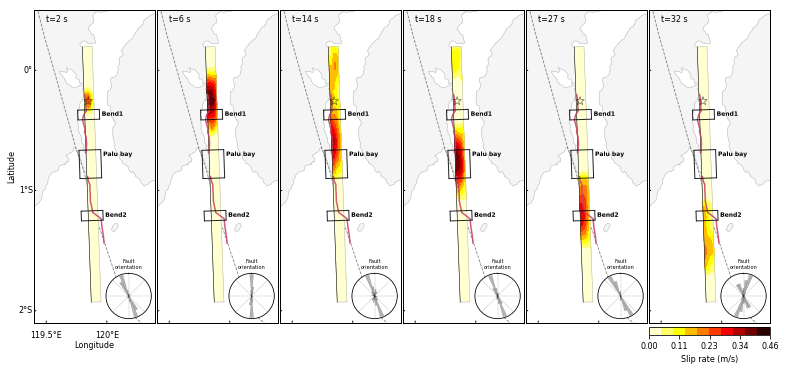

In [28]:
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
j = 4 # main model
print(str(model[j]))
snapind = [207, 214, 218, 228]
m_mllist = []; m_mllist_weight = []
latlist = []
figlocind = 0
figlochori = 0

fig=plt.figure(figsize=figsize)
#for panel in np.arange(1, 41, 1):
for panel in [2, 6, 14, 18, 27, 32]:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(200+panel)+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]; maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    latlist.append(lat[argmaxslip])
    tmp = [];slipHist = []
    for i in range(len(strike)):
        tmp0 = strike[i]
        if tmp0 > 88 and tmp0 < 268:
            tmp0 = tmp0 + 180
        if slip[i] > 0:
            tmp.append(tmp0)
            slipHist.append(slip[i])
    for i in range(len(tmp)):
        if tmp[i] > 360:
            tmp[i] = tmp[i] - 360    
    
    #if panel == 1 or panel == 11 or panel == 21 or panel == 31:
    #    figlocind = 1
    #    figlochori += 1
        
    initialyloc = 0.8749223321178733 - 0.11248705535297888
    #ax=fig.add_axes([1.925 + 0.08, initialyloc - 0.1324870553529789 * (figlocind), 0.11248705535297888, 0.11248705535297888], projection='polar')
    ax=fig.add_axes([0.278+(0.3 + 0.005)*figlocind, 0.11, 0.11248705535297888, 0.11248705535297888], projection='polar')                  

    figlocind += 1
    axp=ax.get_position()
    
    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(tmp, bin_edges)
    
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color='C7', edgecolor='k', linewidth=0.1)
    x = [ (bin_edges[i-1]+bin_edges[i])/2 for i in range(1, len(bin_edges)) ]
    #print(number_of_strikes)
    #ax.bar(np.deg2rad(x), np.deg2rad(number_of_strikes), width=np.deg2rad(10), bottom=0.0, color='C7', edgecolor='k', linewidth=0.35)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 45), labels=[])
    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2000), angle=0, labels=[])
    #ax.set_title('Rose Diagram of the "Fault System"', y=1.10, fontsize=15)
    ax.set_xticklabels([])
    ax.grid(linewidth=0.35)
    ax.set_axisbelow(True)
    ax.set_zorder(100)  # default zorder is 0 for ax1 and ax2
    axp = ax.get_position()
    fig.text(axp.x0 + (axp.x1-axp.x0)/2, axp.y1+0.01, 'Fault\norientation', size=5, va='bottom', ha='center')
    #ax.set_title('Strike\norientation', size=4)
    #ax.patch.set_visible(False)

############################################################################
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
strike_flag=0; slip_flag=0; beach_flag=0
fignums = ['(a)', '(b)', '(c)']
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.4; lonmax=120.4; latmin=-2.1; latmax=0.5
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
          rsphere=(6378137.00,6356752.3142),resolution='h',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=0.3; mapheight=mapwidth/aspect
j = 4 # main model
data=np.loadtxt('model_'+str(model[j])+'/FFM_DCpreferred.txt', skiprows=1)
lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
xloc, yloc = data[:,10], data[:,11]
data=np.loadtxt('model_'+str(model[j])+'/knot_value_'+str(model[j])+'.dat_rim', usecols=(2, 3))
limlon, limlat, limlontop, limlattop=data[:,1], data[:,0], data[2:4,1], data[2:4,0]

lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=1, skip_footer=len(lines)-2)
moment, mw, h0, vr=fort40[0], fort40[1], fort40[5], fort40[6]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=3, skip_footer=len(lines)-4)
model_str, model_dip=fort40[0], fort40[1]
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=5, skip_footer=len(lines)-6)
model_t_int, model_jtn=fort40[6], fort40[7]
lines=linecache.getlines('model_'+str(model[j])+'/fort.40')
fort40=np.genfromtxt('model_'+str(model[j])+'/fort.40', skip_header=7, skip_footer=len(lines)-8)
variance=fort40[0]    
note='Model plane (Strike; '+str(model_str)+', Dip; '+str(model_dip)+'), \nVariance: '+\
str(variance)+', VrMax; '+str(vr)+', JTN: '+str(model_jtn)
#fig.text(axp.x0, axp.y1+0.01, note, va='bottom', ha='left', size=8)
cmap=plt.get_cmap('hot_r')
#cmap=plt.get_cmap('cividis')

dataInSARnorth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_north.gmt', comments='#')
dataInSARsouth=np.loadtxt('Bao+2019NatGeosci/Rupture_pick_ALOS2_A126-A127_azoff_south.gmt', comments='#')
snapind = [202, 206, 214, 218, 227, 232]
timeind = [2, 6, 14, 18, 27, 32]
for panel in [0, 1, 2, 3, 4, 5]:
    ax=fig.add_axes([0.1+(mapwidth + 0.005)*panel, 0.1, mapwidth, mapheight])
    axp=ax.get_position()
    fig.text(axp.x0+0.03, axp.y1-0.01, 't='+str(timeind[panel])+' s', ha='left', va='top')
    m.drawmapboundary(fill_color='#f5f5f5')
    m.fillcontinents(color='w')
    if panel == 0:
        m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,1], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
        #axp = ax.get_position()
        #fig.text(axp.x0+0.005, axp.y1+0.001, '(a)', ha='left', va='bottom', weight='bold')

    else:
        m.drawparallels(np.arange(-80.,81.,1),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')        
        m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5, zorder=2)
    #ax.set_xlabel('Longitude', labelpad=18)
    if panel == 0:
        ax.set_ylabel('Latitude', labelpad=18)
        ax.set_xlabel('Longitude', labelpad=18)

    x, y=m(limlon, limlat)
    ax.plot(x, y, color='C7', zorder=50, lw=0.5, solid_joinstyle='miter')
    x, y=m(limlontop, limlattop)
    ax.plot(x, y, color='k', zorder=50, lw=0.5)

    ax = plt.gca()

    #if panel == 1:
    data=np.loadtxt('model_'+str(model[j])+'/snap_1s_'+str(snapind[panel])+'.txt', skiprows=1)
    lon, lat, slip = data[:,13], data[:,14], data[:,4]
    strike = data[:,9]
    maxslip = data[0,8]
    argmaxslip = np.argmax(slip)
    #lon, lat, slip, strike, dip, rake=data[:,2], data[:,3],data[:,1], data[:,7], data[:,8],data[:,9]
    #xloc, yloc = data[:,10], data[:,11]
    xi=np.linspace(lon.min(), lon.max(), 1000)
    yi=np.linspace(lat.min(), lat.max(), 1000)
    X,Y= np.meshgrid(xi,yi)
    X, Y=m(X, Y)
    resampled = griddata(lon, lat, slip, xi, yi,'linear')
    interval = np.linspace(0, maxslip, 11)
    sc=ax.contourf(X, Y, resampled, interval, cmap=cmap, vmin=0, vmax=maxslip, zorder=10, alpha=1)

    x, y=m(elon, elat)
    ax.scatter(x, y, s=80, marker='*', facecolor='none', edgecolor='k', alpha=0.8, zorder=101, lw=0.5)
    #ax.scatter([], [], s=20, marker='*', facecolor='none', edgecolor='C7', alpha=0.8, zorder=101, lw=0.5, 
    #           label='Epicenter (USGS NEIC)')
    
    x, y =m(dataInSARnorth[:,0], dataInSARnorth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100, label='Surface-rupture trace (Bao et al. 2019)')
    x, y =m(dataInSARsouth[:,0], dataInSARsouth[:,1])
    ax.plot(x, y, color='#c83c65', lw=1.5, alpha=0.85, zorder=100)

    data=np.loadtxt('Belleir2006Tectono_PKF_MF_traced.txt', comments='#')
    sx, sy = 49.35, 49.277
    tmplon, tmplat = data[:,0] / sx + 119.0, - data[:,1] / sy
    tmplon = np.insert(tmplon, 0, 119.346)
    tmplat = np.insert(tmplat, 0, 0.834)
    x, y=m(tmplon, tmplat)
    ax.plot(x, y, zorder=2, lw=0.8, color='k', alpha=0.5, linestyle='--', 
            label='Palu-Koro fault (Bellier et al. 2006)')
    #if panel == 3:
    #    plt.legend(loc='upper right', fontsize=5)

    arrow_params = {'shape': 'full', 'overhang':0.5, 'head_width':0, 'head_length':0}
        
    bend_index = 0
    for k, distance in enumerate(bx):
        g=geod.Direct(elat, elon, 358.0, distance*1e3)
        gx, gy = m(g['lon2'], g['lat2'])
        g_p=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, 10.0*1e3)
        g_m=geod.Direct(g['lat2'], g['lon2'], 358.0-90.0, -10.0*1e3)
        glon = g_p['lon2'], g_m['lon2']
        glat = g_p['lat2'], g_m['lat2']
        gx, gy = m(glon, glat)
        ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
        if k%2 == 0:
            g=geod.Direct(g_m['lat2'], g_m['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=100, solid_capstyle='round')
            x, y = m(g['lon1']+0.02, g['lat1']-0.02)
            if distance >= -69 and distance <= -45:
                text=ax.text(x, y, 'Palu bay', size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            else:
                bend_index += 1
                text=ax.text(x, y, 'Bend'+str(bend_index), size=6, weight='bold', color='k', va='top', ha='left')
                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])
            g=geod.Direct(g_p['lat2'], g_p['lon2'], 358.0, -(bx[k]-bx[k+1])*1e3)
            glon = g['lon1'], g['lon2']
            glat = g['lat1'], g['lat2']
            gx, gy = m(glon, glat)
            ax.plot(gx, gy, color='k', linewidth=1, alpha=0.85, zorder=1020, solid_capstyle='round')

    if panel == 5:
        cax=fig.add_axes([axp.x0, axp.y0-0.03, axp.x1-axp.x0, 0.02])
        cbar=plt.colorbar(sc, cax=cax, ticks=np.linspace(0, maxslip, 5), format='%.2f', label='Slip rate (m/s)', orientation='horizontal')
        
plt.savefig('../pubFigure/figureGraphicalAbstractRose.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../pubFigure/figureGraphicalAbstractRose.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Snapshot of slip

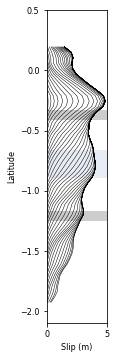

In [29]:
#time evolution
data=np.loadtxt('epicenter.dat')
elon, elat=(data[1], data[0])
lonmin=119.4; lonmax=120.4; latmin=-2.1; latmax=0.5
model=np.loadtxt('modellist.txt', dtype=int, usecols=0)
for i in np.arange(4, 5, 1):
    lines=linecache.getlines('model_'+str(model[i])+'/fort.40_'+str(model[i]))
    fort40=np.genfromtxt('model_'+str(model[i])+'/fort.40_'+str(model[i]), skip_header=5, skip_footer=len(lines)-6)
    model_t_int, model_jtn, model_icmn=fort40[6], fort40[7], fort40[8]
    model_mm = int(fort40[2])
    
    data=np.loadtxt('model_'+str(model[i])+'/slip-rate-time_along_strike.txt', skiprows=1)
    t, x, amp = data[:,0], data[:,1], data[:,3]
    proj_lat = [ geod.Direct(elat, elon, 358, x[i]*1e3)['lat2'] for i in range(len(x)) ]
    proj_bx = [ geod.Direct(elat, elon, 358, bx[i]*1e3)['lat2'] for i in range(len(bx)) ]

    timestep = 40
    dt = 1.0
    
    fig=plt.figure(figsize=(5.6, 5.6))
    ax=fig.add_axes([0.1, 0.1, 0.15, 0.8749223321178733-0.1])
    #ax=fig.add_axes([0.1, 0.1, 0.5, 0.2])
    axp=ax.get_position()
    
    cmap=plt.get_cmap('Spectral')
    
    numsnap = timestep
    accum_amp = np.zeros(model_mm)
    for j in np.arange(0, numsnap, 1):
        pos_x = []
        pos_amp = []
        for k in range(model_mm):
            #pos_x.append(x[k*timestep + j])
            pos_x.append(proj_lat[k*timestep + j])
            pos_amp.append(amp[k*timestep + j] * dt)
        
        accum_amp = accum_amp + np.array(pos_amp)
        color = cmap(j/numsnap)
        #ax.plot(pos_x, pos_amp, color=color, lw=0.5, alpha=1)
        #if j % 10 == 0:
        #    ax.plot(pos_x, accum_amp, color='k', lw=0.5, alpha=1, linestyle='--')
        #    text = ax.text(pos_x[15], accum_amp[15], str(j+1)+' s', size=3)
        #    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.85), path_effects.Normal()])
        #else:
        ax.plot(accum_amp, pos_x, color='k', lw=0.5, alpha=1)
        #ax.plot(pos_x, accum_amp, color='k', lw=0.75, alpha=1)
        
    ax.axhspan(proj_bx[0], proj_bx[1], edgecolor='none', facecolor='k', zorder=0, alpha=0.2)
    #ax.text(bx[1] - (bx[1]-bx[0])/2, max(accum_amp), 'B1', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axhspan(proj_bx[2], proj_bx[3], edgecolor='none', facecolor='C2', zorder=0, alpha=0.2)
    #ax.text(bx[3] - (bx[3]-bx[2])/2, max(accum_amp), 'Palu bay', va='bottom', ha='center', color='k', size=6, weight='bold')
    ax.axhspan(proj_bx[4], proj_bx[5], edgecolor='none', facecolor='k', zorder=0, alpha=0.2)
    #ax.text(bx[5] - (bx[5]-bx[4])/2, max(accum_amp), 'B2', va='bottom', ha='center', color='k', size=6, weight='bold')

    
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Slip (m)')
    #ax.set_ylim(max(amp)*dt*0.25, max(amp)*dt)
    #ax.set_ylim(min(x), max(x))
    ax.set_xlim(0, max(accum_amp)+0.15)
    ax.set_ylim(latmin, latmax)
    #ax.set_yticklabels([])
    
    #axp=ax.get_position()
    #cax=fig.add_axes([axp.x1+0.01, axp.y0, 0.02, axp.y1-axp.y0])
    #norm=mpl.colors.Normalize(vmin=0, vmax=numsnap*dt)
    #cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    #cb.set_label('Time (s)')

    plt.savefig('../pubFigure/timeevo_line_'+str(model[i])+'.png', bbox_inches="tight", pad_inches=0.1)
    plt.show()

In [30]:
nbpath = '/Users/ryo/GoogleDrive/Work/2018Indonesia/'
os.chdir(nbpath)
print('Now back at home dir: '+os.getcwd())

Now back at home dir: /Users/Ryo/GoogleDrive/Work/2018Indonesia
